# 세상에서 가장 가벼운 단기 전력 수요 예측 모델
**1. 개요**
>- 일반적으로 전력 수요 예측 문제는 기상 정보를 예측 변수로 활용하여 풀이됩니다. 하지만 초단기 예측의 관점에서 기상 정보의 방대한 양과 높은 결측률은 장애물로 작용합니다.
>- 만약 기상 정보 없이 전력 수요 예측이 가능하다면 어떨까요?
>- 배로 가벼운 데이터 양, 처리 비용으로 인한 경제성을 기대할 수 있습니다.

**2. 가설 도출**
> - 전력 수요는 안정적인 계절성을 띄는 시계열 데이터이므로 '과거의 패턴만으로 미래의 전력 수요 예측이 가능하다.'는 가설을 수립합니다.
> - EDA를 통해 해당 가설의 유효성을 판단하고, 유효할 시 기상 인자를 포함한 대조군과의 비교를 통해 가설을 입증합니다.

**3. 분석 기간**
>- 분석 대상 기간 : ‘23.3.13(월) ~ 3.19(일)(1주일, 5분 단위)


In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import datetime, date, timedelta
import datetime
from dateutil.relativedelta import relativedelta

import requests
from bs4 import BeautifulSoup
!pip install selenium
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
import time
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import gc
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family="AppleGothic")

plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/u

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/DL Project/Final/eda-data/'

## **A. 데이터 수집**

---



### **A-1. 기상 정보 수집 및 전처리**

**1. 기상정보 수집 개요**
>5분 단위의 전력수요량을 예측하기 위해 기상 및 전력수요 데이터를 수집 및 가공하였습니다.\
>기상정보의 경우, ASOS 종관 기상 관측 정보를 수집하여 데이터셋으로 활용하였습니다.\
>단, 5분단위 ASOS 데이터를 기상청 HUB API에서 제공하지 않는 상황임으로, 기상청 > 기상자료개방포털 > 종관기상관측(ASOS) 페이지를 크롤링하여 데이터셋을 수집했습니다

**2. 기상정보 데이터 수집 절차는 아래와 같습니다.**
>1. <a href = 'https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1'>기상청 기상자료 개방포털</a> ASOS 데이터크롤링 및 압축 해제
>2. 합치고자 하는 csv 파일을 선택하여 합치기 및 5분 간격 데이터 분리 
>3. 관측소 ID별로 행이 존재하지 않는 시간대를 Null값 행으로 채워넣기 및 저장

*종관 기상 관측 (ASOS) : 종관기상관측이란 정해진 시각의 대기 상태를 파악하기 위해 모든 관측소에서 같은 시각에 실시하는 지상관측을 말합니다. 시정, 구름, 증발량, 일기현상 등 일부 목측 요소를 제외하고 종관기상관측장비(ASOS, Automated Synoptic Observing System)를 이용해 자동으로 관측*


In [ ]:
## ---- 1. 기상청 기상자료 개방포털 ASOS 데이터크롤링 (Selenium, Python) -----
service = Service('./driver/chromedriver.exe')
driver = webdriver.Chrome(service = service)
driver.get('https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36&tabNo=1')

time.sleep(3)
driver.find_element(By.XPATH, '/html/body/div[2]/header/div[2]/div/div/ul[2]/li[2]/a').click() # 상단 로그인 버튼 클릭
driver.find_element(By.XPATH, '//*[@id="loginId"]').send_keys('nicloud@kakao.com') # 아이디(이메일) 입력
driver.find_element(By.XPATH, '//*[@id="passwordNo"]').send_keys('ehenr8199!') # 비밀번호 입력
driver.find_element(By.XPATH, '/html/body/div[3]/div/div/div[2]/form/div[1]/div/button').click() # 로그인 확인 버튼 클릭

start_year = '2020'
end_year = '2023'
data_type = '분 자료'

driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[3]/form/div/div[1]/dl[2]/dd/select[1]').send_keys(start_year) # 시작연도
time.sleep(1)
driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[3]/form/div/div[1]/dl[2]/dd/select[3]').send_keys(end_year) # 마지막연도
time.sleep(1)
driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[4]/div[1]/select').send_keys('50') # 1개의 화면에 노출될 파일의 갯수 : 50개
time.sleep(1)
driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[3]/form/div/div[1]/dl[1]/dd/select').send_keys(data_type) # 자료형태 선택
time.sleep(1)
driver.find_element(By.XPATH, '//*[@id="ztree_1_check"]').click() # '전체' 데이터 선택
time.sleep(1)
driver.find_element(By.XPATH, '/html/body/div[2]/div[1]/div/div[2]/div[3]/div[3]/form/div/div[3]/button').click() # 조회 버튼 클릭


# 페이지의 개수 계산하기
# (1개의 화면에 노출될 파일의 갯수와 전체 자료의 갯수를 활용하여 페이지의 개수를 계산합니다)
num_of_data = int(driver.find_element(By.XPATH, '//*[@id="wrap_content"]/div[4]/div[1]/span/strong').text.split(' ')[1][:-1])
if num_of_data % 50 == 0:
    page_length = num_of_data // 50
else:
    page_length = num_of_data // 50 + 1


# 페이지별 압축파일 다운로드 하기 (수기로 압축 해제)
from tqdm import tqdm

for page_num in tqdm(range(1, page_length + 1)):
    if page_num % 10 == 0:
        driver.find_element(By.XPATH, '//*[@id="checkAll"]').click() # 전체 선택
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[2]/a').click() # 다운로드 버튼 클릭
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="reqstPurposeCd7"]').click() # 다운로드 목적 선택
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="wrap-datapop"]/div/div[2]/div/a[2]').click() # 신청 클릭
        time.sleep(1)
        if page_num != page_length:
            driver.find_element(By.XPATH, '//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[1]/ul/li[13]/a').click() # 다음 페이지 클릭
            time.sleep(15)
        else:
            break
    else:
        driver.find_element(By.XPATH, '//*[@id="checkAll"]').click() # 전체 선택
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[2]/a').click() # 다운로드 버튼 클릭
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="reqstPurposeCd7"]').click() # 다운로드 목적 선택
        time.sleep(1)
        driver.find_element(By.XPATH, '//*[@id="wrap-datapop"]/div/div[2]/div/a[2]').click() # 신청 클릭
        time.sleep(1)
        if page_num != page_length:
            XPATH = '//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[1]/ul/li['+ str(page_num % 10 + 3) +']/a'
            driver.find_element(By.XPATH, XPATH).click() # 다음 페이지 클릭
            time.sleep(15)
        else:
            break

In [ ]:
## ---- 2. 합치고자 하는 csv 파일을 선택하여 합치기 및 5분 간격 데이터 분리 -----

# 합칠 데이터 리스트 가져오기 및 개수 확인 
# 2020년부터 2023년까지의 데이터를 합치려고 할 때 파일의 개수
# 관측소의 개수 97개 * 8개의 파일 = 776개

import os
from tqdm import tqdm
import pandas as pd

files = os.listdir('your path')

def target(x):
    keywords = ['2020_2020',
                '2021-01_2021-12',
                '2022-01_2022-12',
                '2023-01_2023-01',
                '2023-02_2023-02',
                '2023-03_2023-03',
                '2023-04_2023-04',
                '2023-05_2023-05']
    
    return any(keyword in x for keyword in keywords)

files = list(filter(target, files))
len(files) # 776

# 하나의 데이터 프레임으로 합치기
base_path = '' # 기본 경로 설정

for idx, file in enumerate(tqdm(files)):
  if idx == 0:
    df_all = pd.read_csv(base_path + file, encoding = 'euc-kr')
  else:
    df =  pd.read_csv(base_path + file, encoding = 'euc-kr')
    df_all = pd.concat([df_all, df])

# 지점과 일시로 정렬하기

df_all = df_all.sort_values(['지점', '일시'])

# 최초의 결합파일 parquet 파일로 저장 (1분, 간격, 5분 간격)

df_all.to_parquet('your path')
df_all[pd.to_datetime(df_all['일시']).dt.minute % 5 == 0].to_parquet('your path')

In [ ]:
## ---- 3. 관측소 ID별로 행이 존재하지 않는 시간대를 Null값 행으로 채워넣기 및 저장 ----

# 기상청 기상자료 개방포털에서 내려받은 자료는 행이 존재하지 않는 시간대가 있습니다.
# 모든 관측소의 기상데이터의 개수가 동일할 수 있도록 맞춰주는 작업이 필요합니다.

import pandas as pd
from tqdm import tqdm

# 1분 간격 ASOS 데이터 불러오기
weather_1minute_ASOS = pd.read_parquet('your path')


# 1분 간격 데이터 중 없어진 시간대를 Null값으로 넣기
STN_list = list(weather_1minute_ASOS['지점'].unique())

for idx, STN in enumerate(tqdm(STN_list)):
  tmp = pd.DataFrame()
  date_list = list(pd.date_range('2020-01-01 00:01', '2023-05-20 00:59', freq = '1min'))
  tmp['일시'] = [str(date)[:-3] for date in date_list]
  tmp = pd.merge(tmp, weather_1minute_ASOS[weather_1minute_ASOS['지점']==STN], on = '일시', how = 'left')
  tmp['지점'] = tmp['지점'].fillna(STN)

  if idx == 0:
    weather_1minute_ASOS_refined = tmp
  else:
    weather_1minute_ASOS_refined = pd.concat([weather_1minute_ASOS_refined, tmp])

right_columns = ['지점',
                 '일시',
                 '기온(°C)',
                 '누적강수량(mm)',
                 '풍향(deg)',
                 '풍속(m/s)',
                 '현지기압(hPa)',
                 '해면기압(hPa)',
                 '습도(%)',
                 '일사(MJ/m^2)',
                 '일조(Sec)']

weather_1minute_ASOS_refined = weather_1minute_ASOS_refined[right_columns]
weather_1minute_ASOS_refined.to_parquet('your path')

import pandas as pd
weather_5minute_ASOS = pd.read_parquet('your path')

from tqdm import tqdm

STN_list = list(weather_5minute_ASOS['지점'].unique())

for idx, STN in enumerate(tqdm(STN_list)):
  tmp = pd.DataFrame()
  date_list = list(pd.date_range('2020-01-01 00:05', '2023-05-20 00:55', freq = '5min'))
  tmp['일시'] = [str(date)[:-3] for date in date_list]
  tmp = pd.merge(tmp, weather_5minute_ASOS[weather_5minute_ASOS['지점']==STN], on = '일시', how = 'left')
  tmp['지점'] = tmp['지점'].fillna(STN)
  tmp
  if idx == 0:
    weather_5minute_ASOS_refined = tmp
  else:
    weather_5minute_ASOS_refined = pd.concat([weather_5minute_ASOS_refined, tmp])

right_columns = ['지점',
                 '일시',
                 '기온(°C)',
                 '누적강수량(mm)',
                 '풍향(deg)',
                 '풍속(m/s)',
                 '현지기압(hPa)',
                 '해면기압(hPa)',
                 '습도(%)',
                 '일사(MJ/m^2)',
                 '일조(Sec)']

weather_5minute_ASOS_refined = weather_5minute_ASOS_refined[right_columns]
weather_5minute_ASOS_refined.to_parquet('your path')

### **A-2. 전력 수요 수집 및 전처리**
>- 전력정보 API를 활용하여 데이터를 수집합니다.
>- 5분단위의 데이터인만큼, 대용량의 데이터가 수집되므로, 파일을 분산 적재합니다.



In [ ]:
## ----- 전력 정보 5분단위 데이터 수집 함수 정의 ------

def get_power_demand(start_date, end_date):
    
    if not isinstance(start_date, str):
        return print('Check start_date')
    elif not isinstance(end_date, str):
        return print('Check end_date')

    import pandas as pd
    import datetime
    import time

    url = f"http://www.happydr.co.kr/?act=&mid=CurrentSupplyView&vid=&view=table&option_date={start_date}"
    start_date = datetime.datetime.strptime(start_date, '%Y%m%d').date()
    end_date = datetime.datetime.strptime(end_date, '%Y%m%d').date()
    tmp_date = start_date

    col_order = pd.read_html(url)[1].columns.tolist()
    df = pd.DataFrame()

    while True:
        url = f"http://www.happydr.co.kr/?act=&mid=CurrentSupplyView&vid=&view=table&option_date={start_date}"
        data = pd.read_html(url)[2]
        data = data[::-1]

        df = pd.concat([df, data], axis=0)
        
        time.sleep(0.2)

        start_date += datetime.timedelta(1)

        if start_date > end_date:
            break

    df.sort_values(by=0, inplace=True)
    df.columns = col_order
    df.reset_index(drop=True, inplace=True)
    print(f'Complete to {tmp_date} to {end_date}')

    return df

In [ ]:
# 데이터 수집 시작
power_demand_2020 = get_power_demand('20200101', '20201231')
power_demand_2021 = get_power_demand('20210101', '20211231')
power_demand_2022 = get_power_demand('20220101', '20221231')
power_demand_2023 = get_power_demand('20230101', '20230320')

# 데이터 결합
power_demand = pd.concat([power_demand_2020, power_demand_2021, power_demand_2022, power_demand_2023])

power_demand = power_demand[['기준시간', '현재부하']]
power_demand['기준시간'] = pd.to_datetime(power_demand['기준시간'], format="%Y-%m-%d %H:%M")
power_demand['현재부하'] = round(power_demand['현재부하'] / 1000, 1)
power_demand['현재부하'] = power_demand['현재부하'].replace(0, np.NaN)

# 데이터 자체가 없는 경우(예. 2022년 4월 6일 16:00 데이터가 없는 경우) 아예 '기준시간' 컬럼에 값이 존재하지 않아 빈 곳을 채움)
power_demand = power_demand.set_index('기준시간').resample('5T').first().reset_index()

# 일별 NaN값을 조회하기 위해 date 컬럼 생성
power_demand['date'] = power_demand['기준시간'].dt.strftime("%Y-%m-%d")
power_demand = power_demand.set_index('기준시간')

power_demand.to_parquet(PATH)

In [ ]:
# ----- 연속으로 NaN값이 있는 데이터의 수를 조회하는 함수 ------

def checkConsNaN(df, date):
    valid = df[df['date'] == date].reset_index()
    valid = valid[valid['현재수요(MW)'].isna()]
    valid['time'] = (valid['기준일시'].dt.hour*60 + valid['기준일시'].dt.minute).astype(int)
    valid['diff'] = valid['time'].diff()
    valid['diff'] = valid['diff'].fillna(0)

    cons = valid[valid['diff']==5]['diff'].count()
    not_cons = valid[valid['diff']!=5]['diff'].count()

    return date, cons, not_cons

# 일별 NaN값이 존재하는지 확인하기 위한 dataframe과 list 생성
missing_values_count = power_demand.groupby('date').count().sort_values('현재부하')
missing_days = missing_values_count[missing_values_count['현재부하'] != 288].sort_values('현재부하', ascending=True).index

tmp_list = []
for date in missing_days:
    tmp_dict = {}
    data = checkConsNaN(elec_demand, date)
    tmp_dict['date'] = data[0]
    tmp_dict['totalNa'] = data[1] + data[2]
    tmp_dict['consecutive'] = data[1]
    tmp_dict['inconsecutive'] = data[2]

    tmp_list.append(tmp_dict)



missing_consecutive = pd.DataFrame(tmp_list)
missing_consecutive

### **A-3. 전력 수요 데이터 보간**
시계열 예측의 경우, 과거의 y값이 가장 중요한 변수로 사용됩니다. 하지만 한국전력공사에서 수집한 5분 단위 전력 수요 데이터의 경우 많은 결측값이 존재합니다.\
보간법이 필수적인 상황에서, 예측 성능을 보장하기 위해 최적의 보간법을 찾을 몇가지 테스트를 진행했습니다.


#### **A-3-a. 보간법 테스트 #1 : 보간 방법론간 비교**
**1. 테스트할 보간 방법론은 아래와 같습니다.**
>- nearest(최근접 이웃 보간법)
>- linear(선형 보간법)
>- polynomial(order=2)(다항식 보간법 2차)
>- polynomial(order=3)(다항식 보간법 3차)
>- spline(order=2)(스플라인 보간법)
>- cubic(3차 보간법)

**2. 실험 방법의 개요는 아래와 같습니다.**
>- 결측치가 없는 날짜를 임의로 선정하여 해당 일의 데이터를 샘플링
>- 샘플에 결측치를 무작위 위치에 부여
>- 샘플을 각 방법을 사용하여 보간
>- 정답 데이터와 비교하여 RMSE를 측정
>- 연속 결측 구간을 1 ~ 150까지 반복
>- 각 연속 결측 구간별 100회씩 테스트 반복

**3. 소결론 : 실험 결과, 선형 보간법이 모든 구간에서 가장 성능이 좋았습니다.**
>- 테스트 결과 linear한 보간법이 모든 구간에서 가장 좋은 성능을 보임
>- 그러나 연속으로 결측치가 많아질수록 선형적으로 RMSE가 증가함을 확인
>- 결측치가 연속으로 길게 있는 구간에 대해서는 linear한 방법 외에 다른 보간 방법이 필요함

In [ ]:
import numpy as np
import pandas as pd

## ------ 최적의 보간법 grid search 실험 #1 -------

score_list = []
for size in range(1,151):
    score = {'size':size,'nearest':0, 'linear':0, 'polynomial2':0, 'polynomial3':0, 'spline2':0, 'cubic':0}
    for iteration in range(100):

        # NaN값이 포함되지 않은 일 샘플 생성
        not_null_samples = missing_values_count[missing_values_count['현재부하'] == 288].index
        not_null_sample_1 = np.random.choice(not_null_samples, 1)
        sample = power_demand[power_demand['date'].isin(not_null_sample_1)].drop(columns='date')
        sample['real_value'] = sample['현재부하'].copy()
        sample.rename(columns={'현재부하':'gen_null'}, inplace=True)
        sample = sample.reset_index(drop=True)

        # NaN 값을 부여하기 시작할 인덱스
        start_index = np.random.randint(1, len(sample)-size-2)

        # NaN 값의 크기
        consecutive_nan_lengths = size -1

        # NaN 값을 부여할 마지막 인덱스
        end_index = start_index + consecutive_nan_lengths

        if end_index < len(sample):
            # 테스트 데이터에 NaN값 부여
            sample.loc[start_index:end_index, 'gen_null'] = np.nan

            for method in ['nearest', 'linear', 'polynomial', 'spline', 'cubic']:
                if method in ['polynomial', 'spline']:
                    for order in [2, 3]:
                        # 보간 후 점수 측정
                        sample[method+str(order)] = sample[['gen_null']].interpolate(method=method, order=order).rename(columns={"gen_null":method+str(order)})[method+str(order)]
                        score[method+str(order)] += np.sqrt(mean_squared_error(sample[sample['gen_null'].isna()].loc[start_index:end_index, 'real_value'],
                                                                                sample[sample['gen_null'].isna()].loc[start_index:end_index, method+str(order)]))
                else:
                    # 보간 후 점수 측정
                    sample[method] = sample[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]
                    score[method] += np.sqrt(mean_squared_error(sample[sample['gen_null'].isna()].loc[start_index:end_index, 'real_value'],
                                                                                sample[sample['gen_null'].isna()].loc[start_index:end_index, method]))
                        
        else:
            # 테스트 데이터에 NaN값 부여
            sample.loc[start_index:, 'gen_null'] = np.nan

            for method in ['nearest', 'linear', 'polynomial', 'spline', 'cubic']:
                if method == 'polynomial':
                    for order in [2, 3]:
                        # 보간 후 점수 측정
                        sample[method+str(order)] = sample[['gen_null']].interpolate(method=method, order=order).rename(columns={"gen_null":method+str(order)})[method+str(order)]
                        score[method+str(order)] += np.sqrt(mean_squared_error(sample[sample['gen_null'].isna()].loc[start_index:, 'real_value'],
                                                                                sample[sample['gen_null'].isna()].loc[start_index:, method+str(order)]))
                else:
                    # 보간 후 점수 측정
                    sample[method] = sample[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]
                    score[method] += np.sqrt(mean_squared_error(sample[sample['gen_null'].isna()].loc[start_index:, 'real_value'],
                                                                                sample[sample['gen_null'].isna()].loc[start_index:, method]))
    print(score)
    score_list.append(score)

test_result = pd.DataFrame(score_list)
test_result.iloc[:,1:] = round(test_result.iloc[:,1:] / 100, 2)

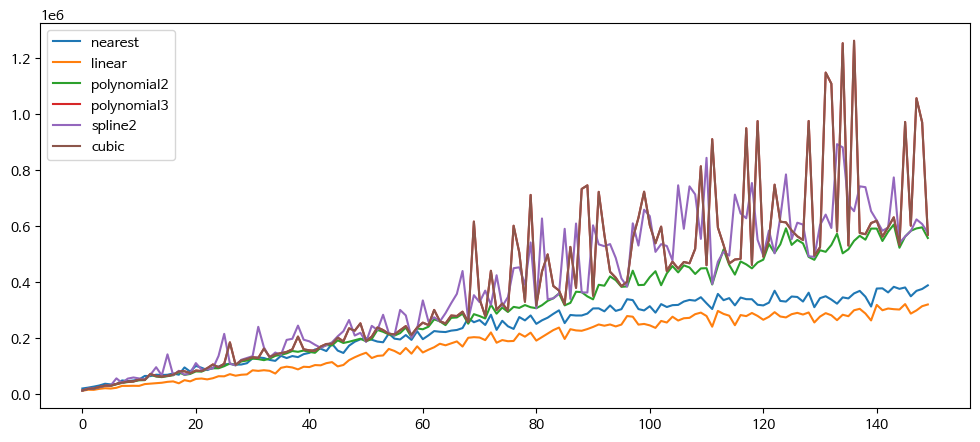

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test_result.iloc[:,1:])
plt.legend(test_result.columns[1:])
plt.show()

#### **A-3-b. 보간법 테스트 #2 : 과거, 미래의 유사 패턴을 활용한 보간**

**1. 기성 보간법 외, 패턴을 활용한 보간법을 테스트했습니다.**
>연속적이며 장기적인 결측 구간에 대해서는 주변일(전 일, 다음 일, 전 주, 다음 주)의 데이터를 사용하여 보간하는 아이디어를 도출했습니다.\
>패턴이 지속된다면, 선형보간보다 정확할 것이라고 예상했습니다.\
>*A-3-b. 보간에 활용할 데이터를 패턴이라 지칭합니다.*

**2. 테스트할 보간 방법론은 아래와 같습니다.**
>- mean_around_weighted : 주변일 data의 평균값으로 보간
>- median_around_weighted : 주변일 data의 중위값으로 보간
>- nearest_around_weighted : 주변일 data 중 NaN값이 아닌 값의 RMSE가 가장 낮은 날짜의 패턴을 사용하여 보간(가장 유사한 형태의 데이터를 사용하여 보간)

**3. 실험 방법 개요는 아래와 같습니다.**
>- 주말의 경우 전일, 다음일과의 비교가 큰 의미가 없어 전주, 다음주의 데이터만 사용
>- 월요일과 금요일의 경우 전일, 다음일을 주말을 건너뛰어 사용
>- 보간된 패턴의 이전, 이후값과의 연결을 위해 수직 보정 실시. 가중치로 보정

**4. 소결론 : median,maen 방법론이 성능이 우세합니다.**
>- 테스트 결과, median, mean 방법이 RMSE가 우세합니다.
>- 예측 후반부로 갈수록, median 방법이 근소하게 우세한 경향을 확인했습니다.
>- 초반 구간에서는 linear한 방법이, 후반 구간에서는 median 보간법이 가장 좋은 성능을 보였습니다.

In [ ]:
## ------ 최적의 보간법 grid search 실험 #2 -------

def mean_around_weighted(original_df, test_df, start_index, end_index):

    # 요일 확인
    weekday = test_df['weekday'][0]

    # 주변일 딕셔너리 생성
    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    # 주변일에 NaN값이 있어 에러가 발생하는 것을 방지하기 위해 전체 데이터에 가장 성능이 좋았던 linear 보간을 사용
    original_df['현재부하'] = original_df[['현재부하']].interpolate(method='linear')['현재부하']

    if weekday in (5, 6): # 주말
        # 주변 날짜 정의
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]

        # 가중치 정의 ==> NaN값 시작 직전 값의 비율로 가중치 조정 (대상일 / 주변일)
        weight_prev_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재수요(MW)']
        weight_next_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재수요(MW)']

        test_df = test_df.loc[start_index:end_index]

        # 가중치 적용
        test_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
        test_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week

        # 평균 계산
        test_df['mean_around'] = test_df[['prev_week', 'next_week']].mean(axis=1)

        return test_df[['mean_around', 'real_value']]

    elif weekday in (1, 2, 3): # 화~목 주변일 정의
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]

    elif weekday == 0: # 월요일 주변일 정의
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4: # 금요일 주변일 정의
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]

    # 가중치 정의 ==> NaN값 시작 직전 값의 비율로 가중치 조정 (대상일 / 주변일)
    weight_prev_day = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_day']].reset_index().loc[start_index-1,'현재부하']
    weight_next_day = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_day']].reset_index().loc[start_index-1,'현재부하']
    weight_prev_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재부하']
    weight_next_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재부하']

    # 가중치 적용
    test_df = test_df.loc[start_index:end_index]
    test_df['prev_day'] = original_df[original_df['date'] == reference_dates['prev_day']].reset_index()['현재부하'] * weight_prev_day
    test_df['next_day'] = original_df[original_df['date'] == reference_dates['next_day']].reset_index()['현재부하'] * weight_next_day
    test_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
    test_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week

    # 평균 계산
    test_df['mean_around'] = test_df[['prev_day', 'next_day', 'prev_week', 'next_week']].mean(axis=1)

    return test_df[['mean_around', 'real_value']]

def median_around_weighted(original_df, test_df, start_index, end_index):

    # 요일 확인
    weekday = test_df['weekday'][0]

    # 주변일 딕셔너리 생성
    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    # 주변일에 NaN값이 있어 에러가 발생하는 것을 방지하기 위해 전체 데이터에 가장 성능이 좋았던 linear 보간을 사용
    original_df['현재부하'] = original_df[['현재부하']].interpolate(method='linear')['현재부하']

    if weekday in (5, 6): # 주말
        # 주변 날짜 정의
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]
        
        # 가중치 정의 ==> NaN값 시작 직전 값의 비율로 가중치 조정 (대상일 / 주변일)
        weight_prev_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재부하']
        weight_next_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재부하']

        test_df = test_df.loc[start_index:end_index]

        # 가중치 적용
        test_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
        test_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week
        # 중위값 계산
        test_df['median_around'] = test_df[['prev_week', 'next_week']].median(axis=1)

        return test_df[['median_around', 'real_value']]

    # 주변 날짜 정의
    elif weekday in (1, 2, 3): # 화~금
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]

    elif weekday == 0: # 월
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4: # 금
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date'])[0]- timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]

    # 가중치 정의 ==> NaN값 시작 직전 값의 비율로 가중치 조정 (대상일 / 주변일)
    weight_prev_day = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_day']].reset_index().loc[start_index-1,'현재부하']
    weight_next_day = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_day']].reset_index().loc[start_index-1,'현재부하']
    weight_prev_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재부하']
    weight_next_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재부하']

    test_df = test_df.loc[start_index:end_index]

    # 가중치 적용
    test_df['prev_day'] = original_df[original_df['date'] == reference_dates['prev_day']].reset_index()['현재부하'] * weight_prev_day
    test_df['next_day'] = original_df[original_df['date'] == reference_dates['next_day']].reset_index()['현재부하'] * weight_next_day
    test_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
    test_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week

    # 중위값 계산
    test_df['median_around'] = test_df[['prev_day', 'next_day', 'prev_week', 'next_week']].median(axis=1)

    return test_df[['median_around', 'real_value']]

def nearest_around_weighted(original_df, test_df, start_index, end_index):
    
    from sklearn.metrics import mean_squared_error

    # 요일 확인
    weekday = test_df['weekday'][0]

    # 주변일 딕셔너리 생성
    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    # 주변일에 NaN값이 있어 에러가 발생하는 것을 방지하기 위해 전체 데이터에 가장 성능이 좋았던 linear 보간을 사용
    original_df['현재부하'] = original_df[['현재부하']].interpolate(method='linear')['현재부하']

    if weekday in (5, 6): # 주말
        # 주변 날짜 정의
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]

        # 가중치 정의 ==> NaN값 시작 직전 값의 비율로 가중치 조정 (대상일 / 주변일)
        weight_prev_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재부하']
        weight_next_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재부하']

        # 가중치 적용(테스트 데이터)
        test_df = test_df.loc[start_index:end_index]
        test_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
        test_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week

        # 가중치 적용(NaN값이 아닌 데이터간의 MSE 확인을 위함)
        check_df = pd.concat([test_df.loc[:start_index], test_df[end_index:]])
        check_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
        check_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week

        # MSE가 낮은 데이터를 사용하여 보간
        mse_prev = mean_squared_error(check_df['real_value'], check_df['prev_week'])
        mse_next = mean_squared_error(check_df['real_value'], check_df['next_week'])

        min_val = min(mse_prev, mse_next)

        if mse_prev == min_val:
            test_df['nearest_around'] = test_df['prev_week']

        elif mse_next == min_val:
            test_df['nearest_around'] = test_df['next_week']

        return test_df[['nearest_around', 'real_value']]

    # 주변 날짜 정의
    elif weekday in (1, 2, 3): # 화~목
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]

    elif weekday == 0: # 월
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4: # 금
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date'])[0] - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date'])[0] + timedelta(days=7)).split(' ')[0]

    # 가중치 정의 ==> NaN값 시작 직전 값의 비율로 가중치 조정 (대상일 / 주변일)
    weight_prev_day = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_day']].reset_index().loc[start_index-1,'현재부하']
    weight_next_day = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_day']].reset_index().loc[start_index-1,'현재부하']
    weight_prev_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_week']].reset_index().loc[start_index-1,'현재부하']
    weight_next_week = original_df[original_df['date'] == test_df['date'][0]].reset_index().loc[start_index-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_week']].reset_index().loc[start_index-1,'현재부하']

    # 가중치 적용(테스트 데이터)
    test_df = test_df.loc[start_index:end_index]
    test_df['prev_day'] = original_df[original_df['date'] == reference_dates['prev_day']].reset_index()['현재부하'] * weight_prev_day
    test_df['next_day'] = original_df[original_df['date'] == reference_dates['next_day']].reset_index()['현재부하'] * weight_next_day
    test_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
    test_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week

    # 가중치 적용(NaN값이 아닌 데이터간의 MSE 확인을 위함)
    check_df = pd.concat([test_df.loc[:start_index], test_df[end_index:]])
    check_df['prev_day'] = original_df[original_df['date'] == reference_dates['prev_day']].reset_index()['현재부하'] * weight_prev_day
    check_df['next_day'] = original_df[original_df['date'] == reference_dates['next_day']].reset_index()['현재부하'] * weight_next_day
    check_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
    check_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week

    # MSE가 낮은 데이터를 사용하여 보간
    mse_prev_day = mean_squared_error(check_df['real_value'], check_df['prev_day'])
    mse_next_day = mean_squared_error(check_df['real_value'], check_df['next_day'])
    mse_prev_week = mean_squared_error(check_df['real_value'], check_df['prev_week'])
    mse_next_week = mean_squared_error(check_df['real_value'], check_df['next_week'])

    min_val = np.min([mse_prev_day, mse_next_day, mse_prev_week, mse_next_week])

    if mse_prev_day == min_val:
        test_df['nearest_around'] = test_df['prev_day']

    elif mse_next_day == min_val:
        test_df['nearest_around'] = test_df['next_day']

    elif mse_prev_week == min_val:
        test_df['nearest_around'] = test_df['prev_week']

    elif mse_next_week == min_val:
        test_df['nearest_around'] = test_df['next_week']

    return test_df[['nearest_around', 'real_value']]

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta

score_list2 = []
for size in range(1, 151):
    score = {'size':size,'linear':0, 'mean_around':0, 'median_around':0, 'nearest_around':0}
    for iteration in range(100):
        # NaN 값이 없는 날 샘플링
        not_null_sample = missing_values_count[missing_values_count['현재부하'] == 288].index

        # 앞, 뒤 날짜의 경우 전주, 다음주 data가 없을 수 있어 샘플에서 제외
        not_null_sample = not_null_sample.drop(not_null_sample[:5])
        not_null_sample = not_null_sample.drop(not_null_sample[-6:])
        not_null_sample_1 = np.random.choice(not_null_sample, 1)
        sample = power_demand[power_demand['date'].isin(not_null_sample_1)]
        sample['real_value'] = sample['현재부하'].copy()
        sample.rename(columns={'현재부하':'gen_null'}, inplace=True)
        sample = sample.reset_index(drop=True)

        # NaN 값을 부여할 시작 지점
        start_index = np.random.randint(3, len(sample)-size-2)

        consecutive_nan_lengths = size 

        # NaN 값을 부여할 마지막 지점
        end_index = start_index + consecutive_nan_lengths

        # NaN값 부여
        sample.loc[start_index:end_index, 'gen_null'] = np.nan

        # 각 방법론별 보간 후 점수 측정
        for method in ['linear', 'mean_around', 'median_around', 'nearest_around']:
            if method == 'linear':
                sample[method] = sample[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]

                score[method] += np.sqrt(mean_squared_error(sample.loc[start_index:end_index, 'real_value'],
                                                            sample.loc[start_index:end_index, method]))

            elif method == 'mean_around':
                sample[method] = mean_around_weighted(power_demand, sample, start_index, end_index)[method]

                score[method] += np.sqrt(mean_squared_error(sample.loc[start_index:end_index, 'real_value'],
                                                            sample.loc[start_index:end_index, method]))
                
            elif method == 'median_around':
                sample[method] = median_around_weighted(power_demand, sample, start_index, end_index)[method]


                score[method] += np.sqrt(mean_squared_error(sample.loc[start_index:end_index, 'real_value'],
                                                            sample.loc[start_index:end_index, method]))
                
            elif method == 'nearest_around':
                sample100[method] = nearest_around_weighted(power_demand, sample, start_index, end_index)[method]

                score[method] += np.sqrt(mean_squared_error(sample.loc[start_index:end_index, 'real_value'],
                                                            sample.loc[start_index:end_index, method]))
  
    print(score)
    score_list2.append(score)

test_result2 = pd.DataFrame(score_list2)
test_result2[test_result2.columns[1:]] = test_result2[test_result2.columns[1:]]/100

**테스트 결과**
- 대체로 median, mean 방법이 RMSE가 적은 것으로 확인
- 뒤쪽으로 갈수록 median 방법이 근소하게 더 RMSE가 낮아보임

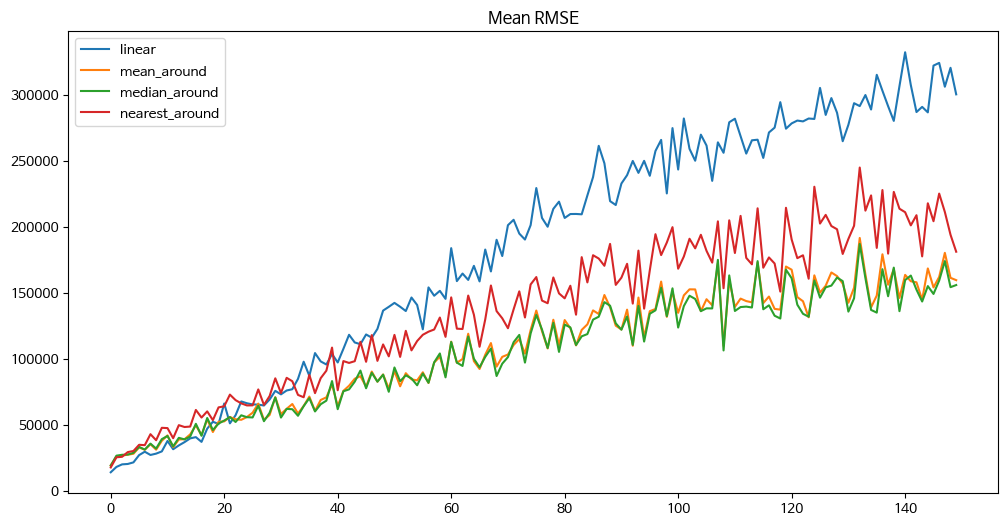

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_result2[test_result2.columns[1:]])
plt.legend(test_result2.columns[1:])
plt.title("Mean RMSE")
plt.show()

- 처음 구간에는 linear한 방법이 더 낮은 RMSE를 기록했으나 뒤로 갈수록 median 보간법이 가장 좋은 성능을 보임

Text(0.5, 1.0, 'Mean RMSE')

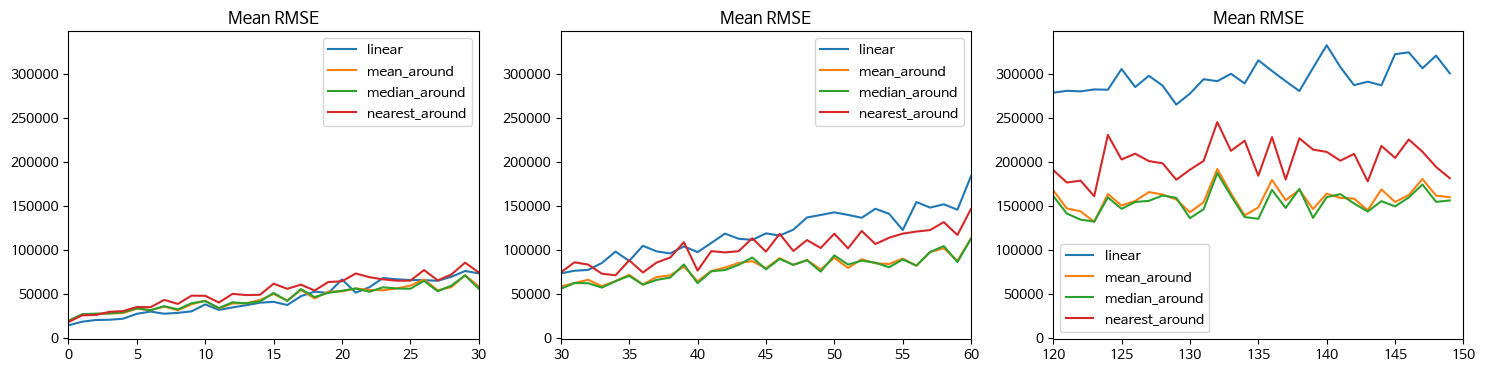

In [ ]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(test_result2[test_result2.columns[1:]])
plt.legend(test_result2.columns[1:])
plt.xlim(left=0, right=30)
plt.title("Mean RMSE")
plt.subplot(1,3,2)
plt.plot(test_result2[test_result2.columns[1:]])
plt.legend(test_result2.columns[1:])
plt.xlim(left=30, right=60)
plt.title("Mean RMSE")
plt.subplot(1,3,3)
plt.plot(test_result2[test_result2.columns[1:]])
plt.legend(test_result2.columns[1:])
plt.xlim(left=120, right=150)
plt.title("Mean RMSE")

- 0~17까지의 연속된 결측 구간에서는 linear가 더 좋은 성능을 보였으나 18에 처음으로 RMSE를 역전하였고, 20 이후로는 median의 성능이 더 좋은 것을 확인

In [ ]:
test_result2['med-lin'] = test_result2['median_around'] - test_result2['linear']
test_result2[['med-lin']].head(30)

med-lin
0    5071.281523
1    8533.973302
2    7248.408812
3    7127.549950
4    7256.772748
5    6177.821357
6    1625.635678
7    8581.999797
8    3845.255991
9    9294.661755
10   3791.263391
11   2184.308520
12   5740.767759
13   2085.928289
14   1350.703600
15  10081.343994
16   4636.759317
17   8056.255837
18  -6249.819568
19    267.457888
20 -12919.655328
21   4737.343060
22  -5108.391953
23 -10508.772347
24 -10541.066263
25  -9860.563717
26   -855.636673
27 -11897.738109
28 -10029.904127
29  -5023.821321

In [ ]:
def random_sample_intp_test(power_demand, cons_num=150):
    count = power_demand.groupby('date').count()
    not_null_sample = count[count['현재부하'] == 288].index
    not_null_sample = not_null_sample.drop(not_null_sample[:5])
    not_null_sample = not_null_sample.drop(not_null_sample[-6:])
    not_null_sample1 = np.random.choice(not_null_sample, 1)
    sample = power_demand[power_demand['date'].isin(not_null_sample1)]
    sample['real_value'] = sample['현재부하'].copy()
    sample.rename(columns={'현재부하':'gen_null'}, inplace=True)
    sample = sample.reset_index(drop=True)

    weekdays = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    weekday = datetime.datetime.strptime(not_null_sample1[0], '%Y-%m-%d').weekday()

    print("date : ", not_null_sample1, "weekday : ", weekdays[weekday])

    start_index = np.random.randint(3, len(sample)-cons_num-2)

    cons_num = cons_num 
    
    end_index = start_index + cons_num

    sample.loc[start_index:end_index, 'gen_null'] = np.nan

    for method in ['linear', 'mean_around', 'median_around', 'nearest_around']:
        if method == 'linear':
            sample[method] = sample[['gen_null']].interpolate(method=method).rename(columns={"gen_null":method})[method]

        elif method == 'mean_around':
            sample[method] = mean_around_weighted(power_demand, sample, start_index, end_index)[method]

        elif method == 'median_around':
            sample[method] = median_around_weighted(power_demand, sample, start_index, end_index)[method]

        elif method == 'nearest_around':
            sample[method] = nearest_around_weighted(power_demand, sample, start_index, end_index)[method]

    sample.loc[:start_index,'linear'] = np.nan
    sample.loc[end_index:,'linear'] = np.nan

    plt.figure(figsize=(15,4))
    plt.plot(sample[sample.columns[3:]])
    plt.legend(sample[sample.columns[3:]])
    plt.figure(figsize=(6,4))
    plt.plot(sample[sample.columns[3:]])
    plt.legend(sample[sample.columns[3:]])
    plt.xlim(left=start_index, right=end_index)
    plt.show()

date :  ['2021-04-23'] weekday :  금요일


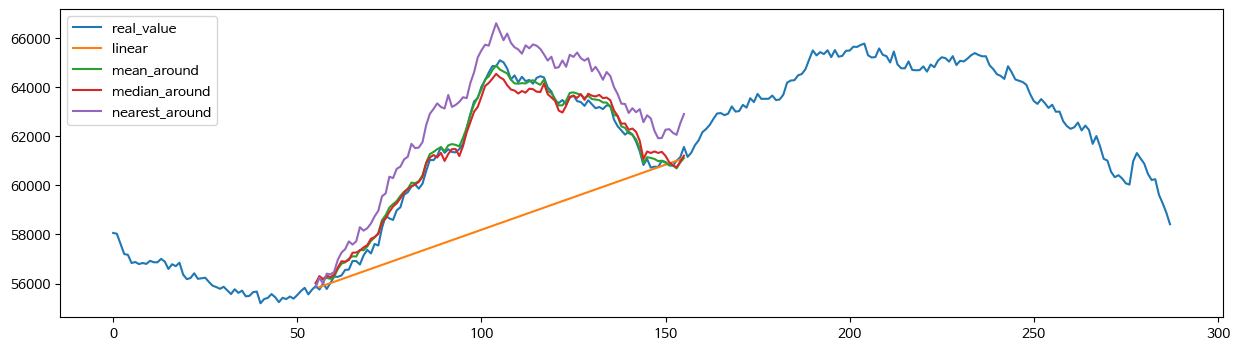

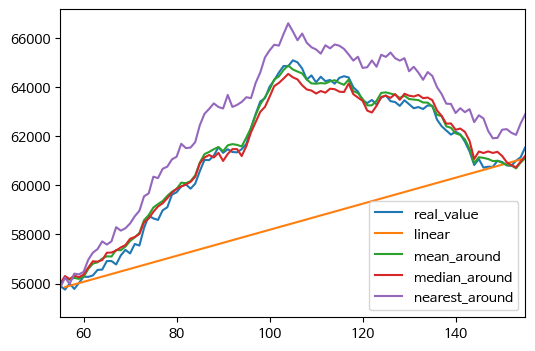

In [ ]:
random_sample_intp_test(power_demand, 100)

#### **A-3-c. 보간법 실행**

**1. 실험 결과를 통한 데이터 보간 규칙을 적용합니다.**
>1. 연속 20일 이상의 결측 구간 : 주변일 패턴의 중앙값으로 보간법 실행
>2. 연속 20일 이하의 결측 구간 : 선형 보간법 실행

- 2022년 4월 28일 데이터의 경우 누락된 데이터를 발견하여 보충</br>
(source : https://epsis.kpx.or.kr/epsisnew/selectEkgeEpsMepRealChart.do?menuId=030300)

In [ ]:
## ----- 데이터 보간 실행 ------

power_demand_220428 = pd.read_csv(PATH + '20220428_power_demand.csv')
idx_220428 = power_demand.loc['2022-04-28'].index
power_demand_220428 = power_demand_220428.set_index(idx_220428)
power_demand.loc['2022-04-28', '현재부하'] = power_demand_220428['현재부하']

power_demand = power_demand.reset_index()
power_demand['기준시간'] = pd.to_datetime(power_demand['기준시간'], format="%Y-%m-%d %H:%M")
power_demand['weekday'] = power_demand['기준시간'].dt.weekday
power_demand = power_demand.set_index('기준시간')


## ----- 연속으로 20 이상 결측치가 있는 구간에는 is_na = 2, 이외 결측치는 is_na = 1, 나머지는 is_na -----

power_demand['is_na'] = power_demand['현재부하'].isna().astype(int)

power_demand.loc['2022-04-06 13:45:00':'2022-04-06 23:55:00', 'is_na'] = 2
power_demand.loc['2022-04-27 13:55:00':'2022-04-27 23:55:00', 'is_na'] = 2
power_demand.loc['2022-08-16 17:50:00':'2022-08-16 23:40:00', 'is_na'] = 2
power_demand.loc['2022-01-16 12:35:00':'2022-01-16 15:40:00', 'is_na'] = 2
power_demand.loc['2018-05-08 21:20:00':'2018-05-08 23:55:00', 'is_na'] = 2



## ----- 연속으로 20이상 결측치가 있는 날짜를 제외하고 나머지 날짜에 대해 linear 보간법 적용 -----

linear_targets = missing_consecutive.sort_values('consecutive', ascending=False)['date'][5:].reset_index(drop=True)

for date in linear_targets:
    power_demand.loc[power_demand['date'] == date, '현재부하'] = power_demand[power_demand['date'] == date]['현재부하'].interpolate(method='linear')



## ----- 20이상 연속 결측치에 대해 주변일 데이터의 중앙값으로 결측치 보간 -----

def median_around_interpolation(original_df, test_df):

    test_df = test_df.reset_index()

    # 20 이상 연속 결측 구간 인덱스 확인
    targ_first_idx, targ_last_idx = test_df[test_df['is_na']==2].index[0], test_df[test_df['is_na']==2].index[-1]

    # 요일 확인
    weekday = test_df['weekday'].max()

    # 주변일 딕셔너리 정의
    reference_dates = {'prev_day':'', 'next_day':'', 'prev_week':'', 'next_week':''}

    if weekday in (5, 6): # 주말
        # 주변일 정의
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date']).max() - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date']).max() + timedelta(days=7)).split(' ')[0]
        
        # 가중치 정의
        weight_prev_week = original_df[original_df['date'] == test_df['date'].max()].reset_index().loc[targ_first_idx-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_week']].reset_index().loc[targ_first_idx-1,'현재부하']
        weight_next_week = original_df[original_df['date'] == test_df['date'].max()].reset_index().loc[targ_first_idx-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_week']].reset_index().loc[targ_first_idx-1,'현재부하']

        test_df = test_df.loc[targ_first_idx:targ_last_idx]
        
        # 가중치 부여
        test_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
        test_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week

        test_df['median_around'] = test_df[['prev_week', 'next_week']].median(axis=1)

        return test_df['median_around'].to_list()

    # 주변일 정의
    elif weekday in (1, 2, 3): # 화~목
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date']).max() - timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date']).max() + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date']).max() - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date']).max() + timedelta(days=7)).split(' ')[0]

    elif weekday == 0: # 월
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date']).max() - timedelta(days=3)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date']).max() + timedelta(days=1)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date']).max() - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date']).max() + timedelta(days=7)).split(' ')[0]
    
    elif weekday == 4: # 금
        reference_dates['prev_day'] = str(pd.to_datetime(test_df['date']).max()- timedelta(days=1)).split(' ')[0]
        reference_dates['next_day'] = str(pd.to_datetime(test_df['date']).max() + timedelta(days=3)).split(' ')[0]
        reference_dates['prev_week'] = str(pd.to_datetime(test_df['date']).max() - timedelta(days=7)).split(' ')[0]
        reference_dates['next_week'] = str(pd.to_datetime(test_df['date']).max() + timedelta(days=7)).split(' ')[0]

    # 가중치 정의
    weight_prev_day = original_df[original_df['date'] == test_df['date'].max()].reset_index().loc[targ_first_idx-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_day']].reset_index().loc[targ_first_idx-1,'현재부하']
    weight_next_day = original_df[original_df['date'] == test_df['date'].max()].reset_index().loc[targ_first_idx-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_day']].reset_index().loc[targ_first_idx-1,'현재부하']
    weight_prev_week = original_df[original_df['date'] == test_df['date'].max()].reset_index().loc[targ_first_idx-1,'현재부하'] / original_df[original_df['date'] == reference_dates['prev_week']].reset_index().loc[targ_first_idx-1,'현재부하']
    weight_next_week = original_df[original_df['date'] == test_df['date'].max()].reset_index().loc[targ_first_idx-1,'현재부하'] / original_df[original_df['date'] == reference_dates['next_week']].reset_index().loc[targ_first_idx-1,'현재부하']

    test_df = test_df.loc[targ_first_idx:targ_last_idx]
    # 가중치 부여
    test_df['prev_day'] = original_df[original_df['date'] == reference_dates['prev_day']].reset_index()['현재부하'] * weight_prev_day
    test_df['next_day'] = original_df[original_df['date'] == reference_dates['next_day']].reset_index()['현재부하'] * weight_next_day
    test_df['prev_week'] = original_df[original_df['date'] == reference_dates['prev_week']].reset_index()['현재부하'] * weight_prev_week
    test_df['next_week'] = original_df[original_df['date'] == reference_dates['next_week']].reset_index()['현재부하'] * weight_next_week

    test_df['median_around'] = test_df[['prev_day', 'next_day', 'prev_week', 'next_week']].median(axis=1)

    return test_df['median_around'].to_list()

median_targets = ['2022-04-06', '2022-04-27', '2022-08-16', '2022-01-16']
for date in median_targets:
    median_values = median_around_interpolation(power_demand, power_demand[power_demand['date']==date])
    power_demand.loc[(power_demand['date']==date) & (power_demand['is_na']==2), '현재부하'] = median_values



## ----- 잔여 단일 결측 데이터 선형 보간 -------

power_demand['현재부하'] = power_demand['현재부하'].interpolate(method='linear')

- 결측치가 연속 20이상 이었던 구간에 대한 시각화
    - 파란색 : 원본 데이터
    - 붉은색 : 보간한 데이터

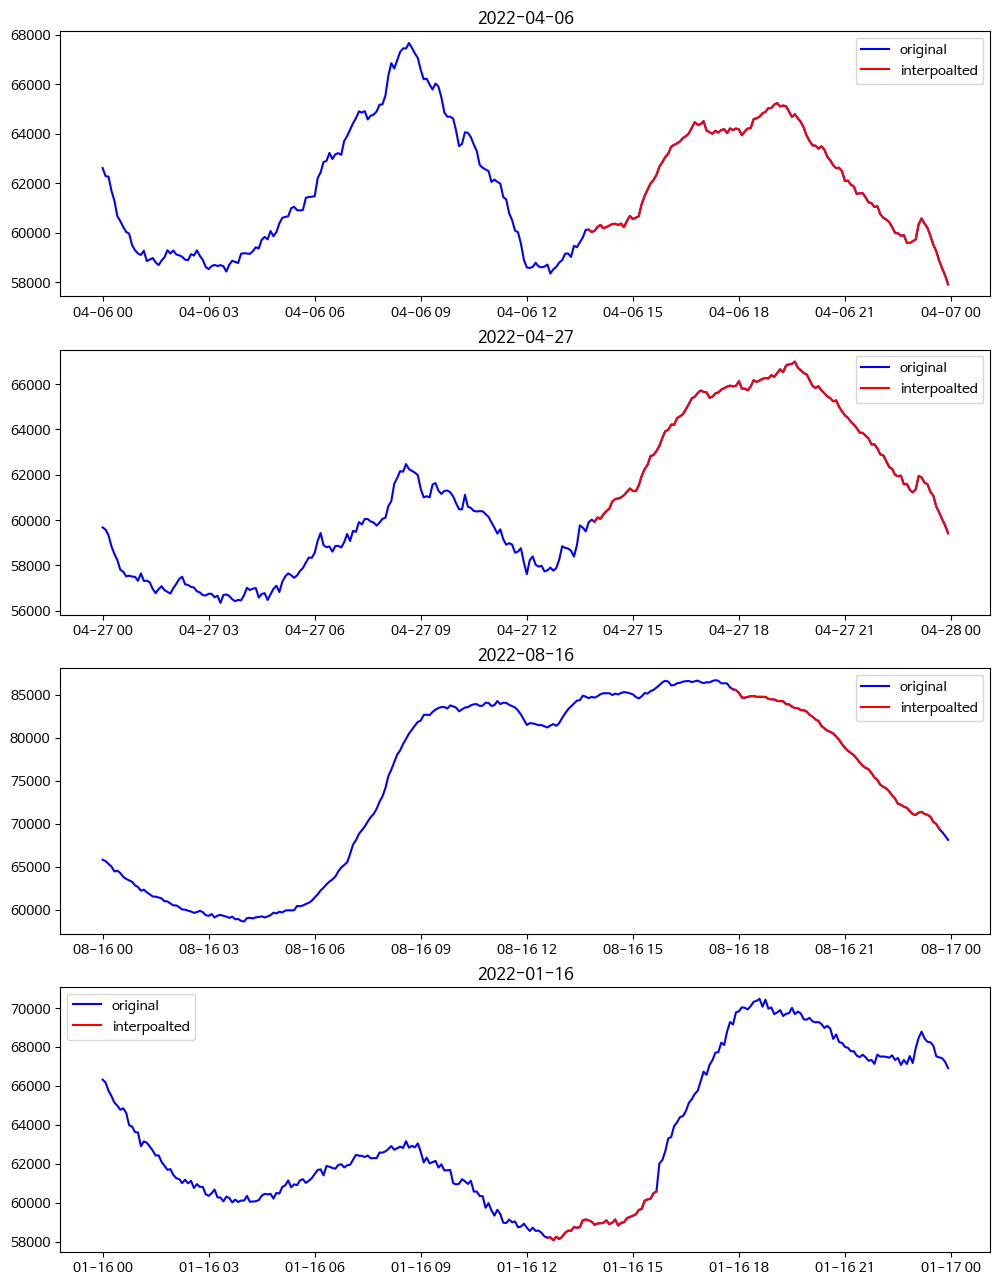

In [ ]:
median_targets = ['2022-04-06', '2022-04-27', '2022-08-16', '2022-01-16']

plt.figure(figsize=(12, 20))
for idx, date in enumerate(median_targets):
    target_df = power_demand[power_demand['date']==date]
    plt.subplot(5,1,idx+1)
    plt.title(date)
    plt.plot(target_df.loc[:target_df[target_df['is_na']==2].index[0]][['현재부하']], color='blue')
    plt.plot(target_df.loc[target_df[target_df['is_na']==2].index[0]:][['현재부하']], color='blue', label='original')
    plt.plot(target_df.loc[target_df[target_df['is_na']==2].index[0]:
                           target_df[target_df['is_na']==2].index[-1]][['현재부하']], color='red', label='interpoalted')
    plt.legend()
plt.show()

---

### **A-4. 공휴일 데이터 수집**

**1. 공휴일 유무는 중요한 변수로 활용될 수 있다 판단했습니다.**
>- 전력 수요의 경우 요일과 주말 여부에 큰 영향을 받는 패턴을 보입니다.
>- 따라서 휴일 유무도 위의 요인과 결이 유사하다 판단하여 수집 후 변수로 활용합니다.

In [ ]:
import pandas as pd
import requests
import json
import time

def getHolidays(year,month,key):
    url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo'

    params = {
            'solYear':str(year),
            'solMonth':str(month).zfill(2),
            'numOfRows':'20',
            '_type':'json',
            'ServiceKey' : key
            }
    
    res = requests.get(url,params=params)
    dic = json.loads(res.text)
    counts = dic['response']['body']['totalCount']

    if counts < 1 :
        return []

    item =  dic['response']['body']['items']['item']

    print(item)

    if counts == 1:
        return [item]

    return item

api_key = 'yJJy5dAw+XW9PSsnnA7wROpORFf3AXL9Cvi9M6YsvpPPlUoJJFwmfT1KVKxIsU2be6EPGFKv3YHLU+DZJ9d4Vw=='

holidays = []

for year in range(2020, 2024):
    for month in range(1,13):
        try:
            holidays.extend(getHolidays(year, month, api_key))
        except:
            time.sleep(2)
            holidays.extend(getHolidays(year, month, api_key))

df_holidays = pd.DataFrame(holidays)
df_holidays['locdate'] = pd.to_datetime(df_holidays['locdate'], format='%Y%m%d')

## **B. EDA**

>- 전력 수요의 연도, 계절, 지역, 산업별 현황과 트렌드를 살펴, 특징을 찾아냅니다.
>- 기상정보와 전력 수요간의 미치는 영향의 정도와 상관성을 파악합니다.

---



### **B-1. 전력 수요 트렌드 및 패턴 EDA**

#### **B-1-a. 전력 수요 데이터의 자기상관관계**

**1. 전력 수요량은 자기상관관계를 가지고 있으며 일정한 트렌드와 주기성을 보입니다.**
>- 자기상관 관계는 99%에서 12시간동안 내려가고 그 다음 12시간동안 다시 상승합니다.
>  - 다음 날의 같은 시간의 전력수요와 높은 자기상관이 있습니다.
>- 이후 1주일을 기준으로 하루씩 지나면서 자기상관관계가 하락하지만 1주일이 지나면 다시 상승합니다.
>  - 같은 시간의 전력수요에 대한 자기상관은 매일 점차 낮아지지만 같은 요일 같은 시간의 자기상관은 높은 수치를 보입니다.
>- 연간 자기상관은 3개월을 기준으로 낮아지고 높아지고를 반복합니다.



In [ ]:
power_demand = pd.read_csv(PATH+'power_demand_interpolated.csv')
power_demand['기준일시'] = pd.to_datetime(power_demand['기준일시'])
power_demand = power_demand.rename(columns={"기준일시":"datetime", "현재수요(MW)":"load"})
power_demand = power_demand.set_index("datetime")
power_demand = power_demand.loc["2020-01-01":"2023-03-19"]

In [ ]:
def auto_correlation_graph(data, weeks):
    acf = sm.tsa.stattools.acf(data, nlags=int(2016*weeks), fft=False, adjusted=True)

    plt.figure(figsize=(12,6))
    plt.plot(acf)
    plt.axhline(y=0, color='red')
    plt.title(f"Autocorrelation Function Graph ~ {weeks} week(s)")
    plt.show()

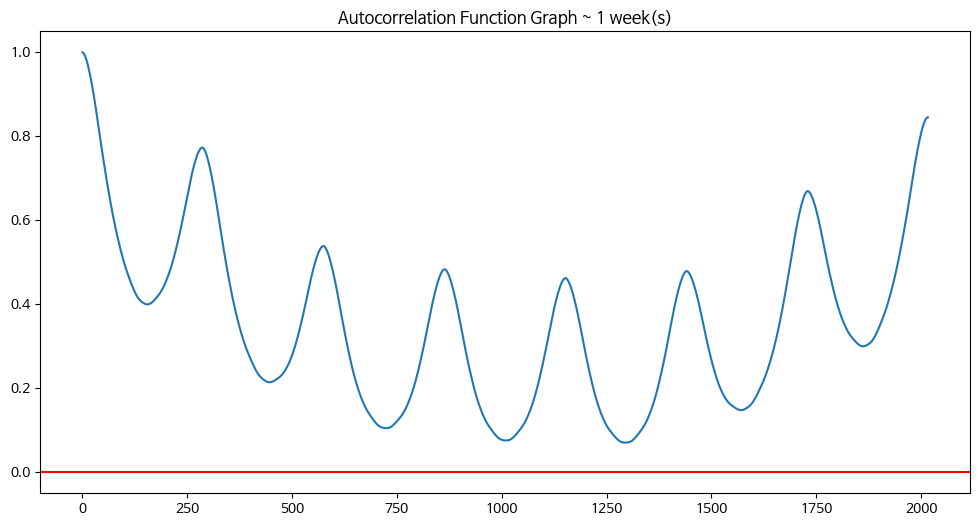

In [ ]:
auto_correlation_graph(power_demand['load'], 1)

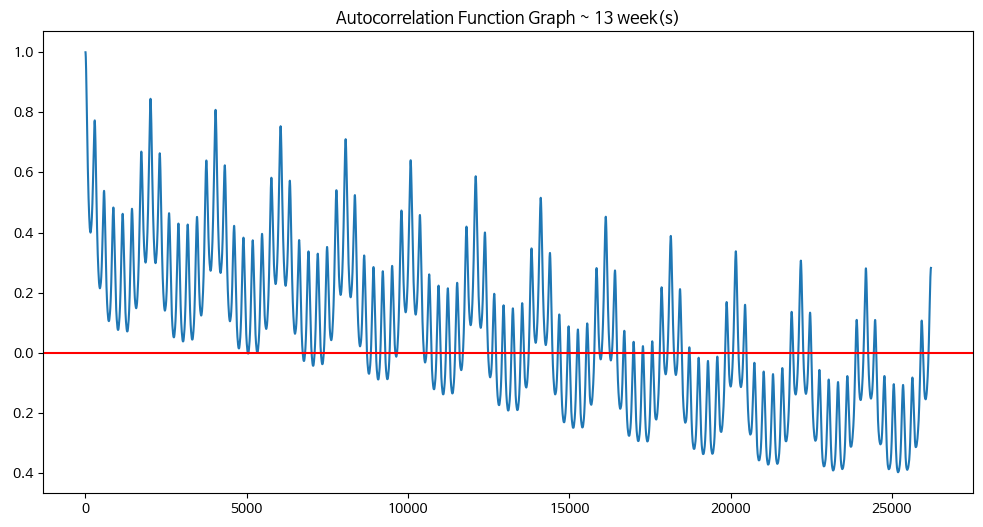

In [ ]:
auto_correlation_graph(power_demand['load'], 13)

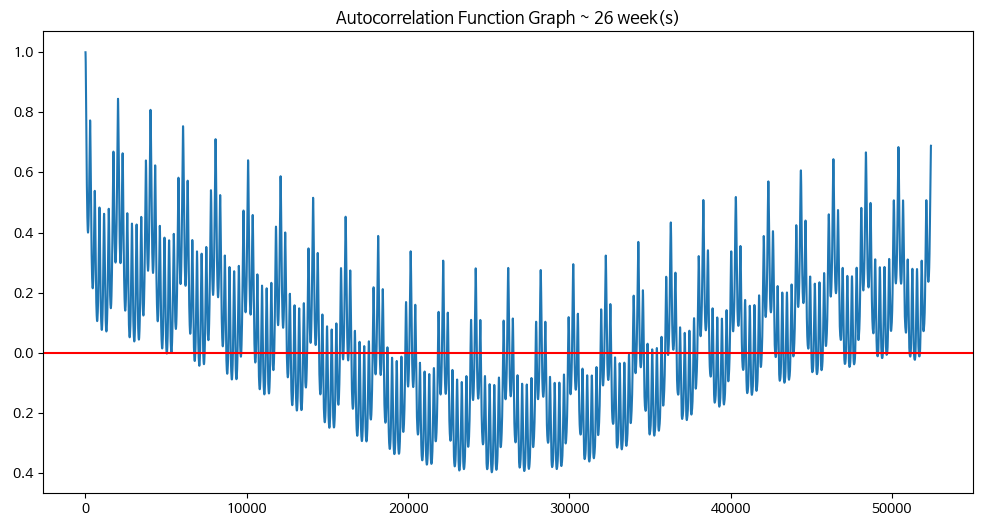

In [ ]:
auto_correlation_graph(power_demand['load'], 26)

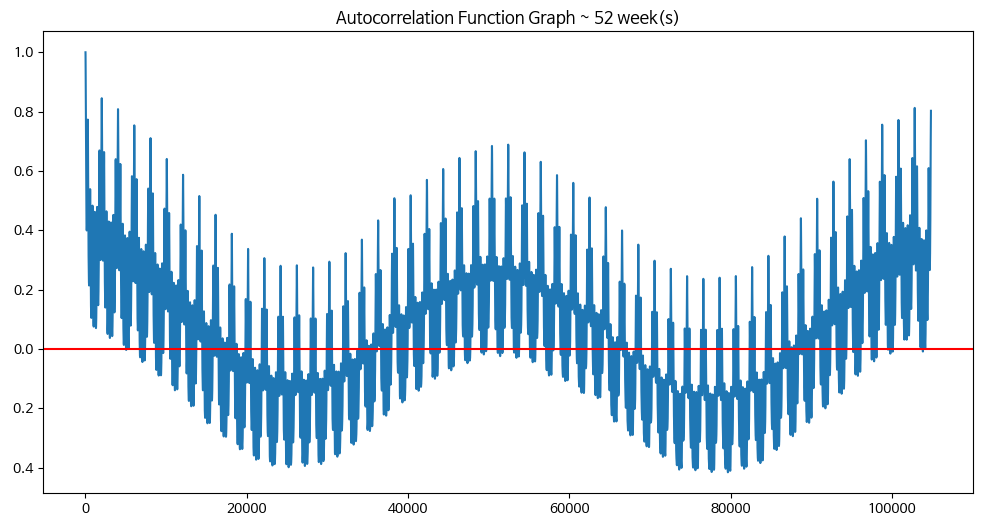

In [ ]:
auto_correlation_graph(power_demand['load'], 52)

#### **B-2-a. 월단위 지역/산업별 전력 수요 현황**


**1. 계약종은 7가지로, 산업,일반,주택,농업,심야,교육,가로등으로 구성됩니다.**

|year|	조회연도|	STRING|	조회연도(YYYY)|
|---|---|---|---|
|month|	조회월|	STRING|	조회월(MM)|
|metro|	시도명|	STRING|	광역자치단체 명(ex:서울특별시, 경기도, 부산광역시 등)|
|city|	시군구명|	STRING|	기초자치단체 명(ex:청주시, 양평군, 강남구 등)|
|cntr|	계약종별|	STRING|	한국전력 전기계약종별(ex:주택용, 일반용 등)|
|custCnt|	고객호수|	NUMBER|	전기사용 고객 호수(호)|
|powerUsage|	전력사용량|	NUMBER|	전력사용량 합계(kWh)|
|bill|	전기요금|	NUMBER|	전기요금 합계(원)|
|unitCost|	평균판매단가|	NUMBER|	전기요금 평균판매 단가(원/kWh)|


**2. 산업용 수요가 총 전력수요 비중의 과반수 이상을 차지합니다.**
>- 산업용 전력 수요는 전체 전력 수요의 과반 이상을 차지합니다. 
>- 산업, 일반, 주택 용도가 전력 수요의 90% 이상을 차지하므로, 공업 지역과 인구 밀집 지역에서 전력 수요가 매우 높다는 것을 의미합니다.
>- 따라서, 인구 대비 전력 수요가 높은 지역이 존재하며, 이를 반영한 기상 대표값을 고려할 수 있습니다.
>- 인구 대비 전력 수요가 높은 지역의 예로 충남과 경북을 예로 들 수 있습니다. 
>- 이 지역에 위치한 대형 공업 단지들은 서울과 유사한 수준의 전력 수요를 생성하고 있습니다.

**3. 대한민국의 전력수요는 지속적으로 우상향하며, 경기도의 성장세가 가파릅니다.**
>- 2018년, 전국 전력 수요가 크게 상승했습니다. 
>    - 전국 전력수요가 크게 상승한 시기와 기록적인 폭염 시기와 겹칩니다.
>- 2019-2020년, 전국 전력 수요가 하락했습니다.
>    - 산업 전력 수요가 높은 경기도와 충남의 일시적인 횡보 및 하락이 요인으로 파악됩니다.
>    - 코로나 유행 시기로, 산업 전력 수요량이 감소했음을 추측할 수 있습니다.
>- 이외, 전체 트렌드는 우상향하는 경향을 보이며, 경기도의 상승폭이 주 요인으로 파악됩니다.

**4. 지역 전력 수요 비중을 기상 대표값의 가중치로 활용할 수 있음을 확인합니다.**
>- 지역 월별 전력 수요의 순위는 변동 없이 안정적입니다.

In [ ]:
## ----- 월단위 지역/산업별 전력 수요 현황 데이터 수집 -----

def crawl_power_demand_data(api_key, start_year, start_month, end_year, end_month):
    metro_code = pd.read_html('https://sgis.kostat.go.kr/developer/html/openApi/api/dataCode/SidoCode.html')
    metro_code = pd.DataFrame(metro_code[0])
    metro_code_list = list(metro_code['코드'].iloc[1:])
    metro_code_list.pop(7) # 세종시 제외
    
    start_date = datetime.strptime(f'{start_year}/{start_month}', '%Y/%m')
    end_date = datetime.strptime(f'{end_year}/{end_month}', '%Y/%m')
    
    tmp_list = []
    while start_date <= end_date:
        year = str(start_date.year)
        month = str(start_date.month).zfill(2)
        print(year + month)
        
        if year + month == f'{end_year}{end_month}':
            break
        
        for i in metro_code_list:
            url = f'https://bigdata.kepco.co.kr/openapi/v1/powerUsage/contractType.do?year={year}&month={month}&metroCd={i}&cityCd=&cntrCd=&apiKey={api_key}&returnType=json'
            response = requests.get(url)
            json_data = response.json()

            for dic in json_data['data']:
                tmp_list.append(dic)

        start_date += relativedelta(months=1)

    power_demand_type_1m_metro = pd.DataFrame(tmp_list)
    power_demand_type_1m_metro['TM'] = pd.to_datetime(power_demand_type_1m_metro.year + ' ' + power_demand_type_1m_metro.month, format='%Y %m')
    power_demand_type_1m_metro.drop(['year', 'month'], axis=1, inplace=True)

    col = list(power_demand_type_1m_metro.columns)
    col.insert(0, col[-1])
    col.pop(-1)
    power_demand_type_1m_metro = power_demand_type_1m_metro[col]

    return power_demand_type_1m_metro


api_key = pd.read_csv(PATH + 'API.csv').key[1]
start_year = 2013
start_month = 5
end_year = 2023
end_month = 4

power_demand_type_1m_metro = crawl_power_demand_data(api_key, start_year, start_month, end_year, end_month)
power_demand_type_1m_metro.to_pickle(PATH + 'power_demand_type_1m_metro.pkl')


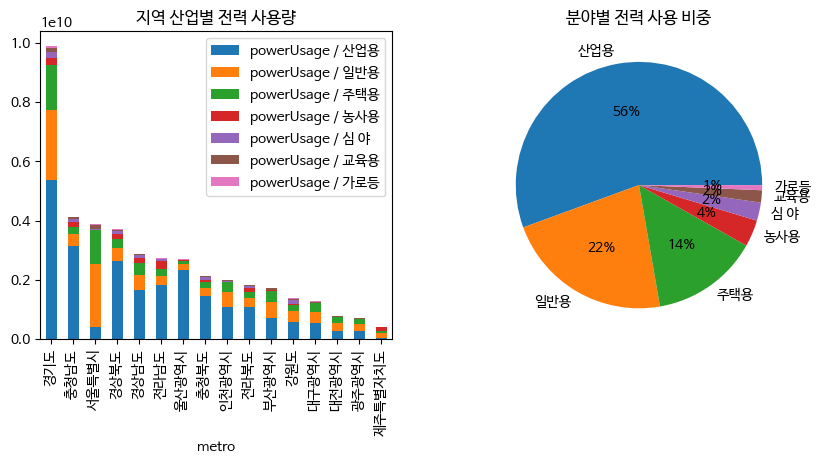

In [ ]:
## ----- # 1. 산업용 수요가 총 전력수요 비중의 과반수 이상을 차지합니다. -----

power_demand_type_1m_metro = pd.read_pickle(PATH + 'power_demand_type_1m_metro.pkl')

def flat_cols(df):
    df.columns = [' / '.join(x) for x in df.columns.to_flat_index()]
    return df

def plot_power_demand(dt):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(hspace=1, wspace=0.2)

    # subplot 1 - 지역 산업별 전력 사용량
    dt_1 = dt[['metro', 'cntr', 'powerUsage']]
    dt_1 = pd.pivot_table(data=dt_1, index='metro', columns='cntr').pipe(flat_cols)
    dt_1 = dt_1.loc[:, dt_1.sum().sort_values(ascending=False).index]
    dt_1.sort_index(ascending=False)
    dt_1['sum'] = dt_1.sum(axis=1)
    dt_1.sort_values(by='sum', ascending=False, inplace=True)
    dt_1.drop(['sum'], axis=1, inplace=True)
    dt_1.plot.bar(stacked=True, ax=ax1)
    ax1.legend()
    ax1.set_title('지역 산업별 전력 사용량')

    # subplot 2 - 분야별 전력 사용 비중
    dt_1m_by = dt.groupby(['cntr']).agg({'powerUsage':'sum'}).reset_index().sort_values(by='powerUsage', ascending=False)
    ax2.pie(data=dt_1m_by, labels=dt_1m_by['cntr'], x=dt_1m_by['powerUsage'], autopct='%1.f%%')
    ax2.set_title('분야별 전력 사용 비중')

    plt.show()

dt_1m = power_demand_type_1m_metro.groupby(['metro', 'TM', 'cntr']).sum().reset_index()
plot_power_demand(dt_1m)


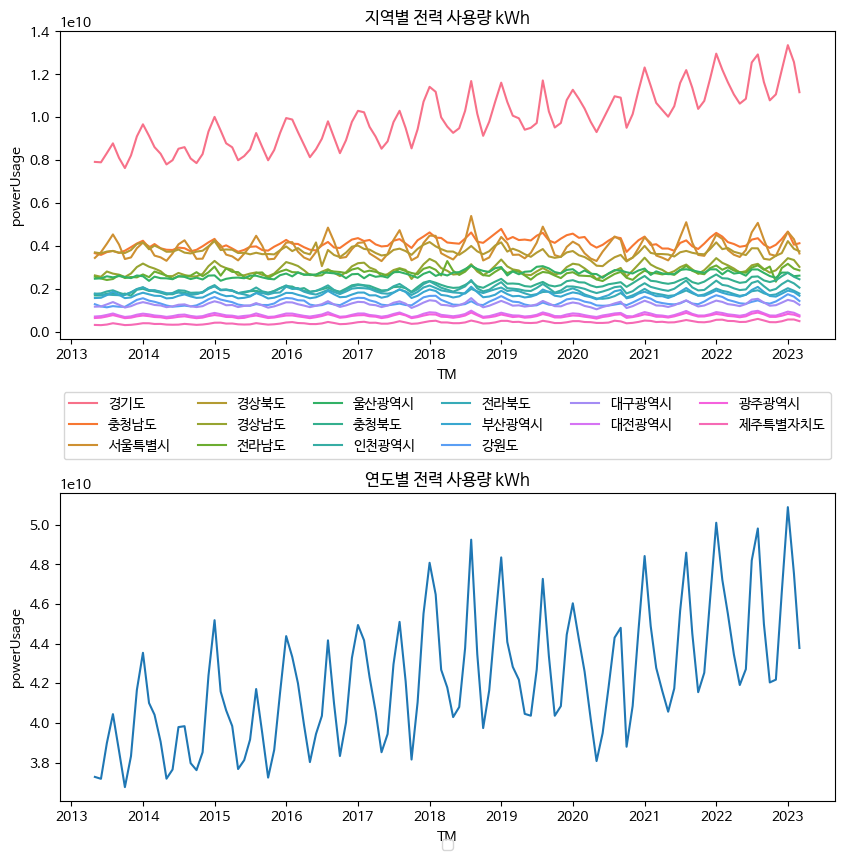

In [ ]:
## ----- 2. 대한민국의 전력수요는 지속적으로 우상향하며, 경기도의 성장세가 가파릅니다. -----
def plot_power_usage(dt):
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    plt.subplots_adjust(hspace=0.5)
    
    dt = dt_1m = power_demand_type_1m_metro.groupby(['metro', 'TM']).sum().reset_index()
    dt_order = dt.groupby('metro').agg({'powerUsage': 'sum'}).reset_index()
    dt_order = dt_order.sort_values(by='powerUsage', ascending=False)
    order = list(dt_order['metro'])

    sns.lineplot(data=dt, x='TM', y='powerUsage', hue='metro', legend='brief', hue_order=order, ax=axes[0])
    axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
    axes[0].set_title('지역별 전력 사용량 kWh')

    dt = power_demand_type_1m_metro.groupby(['TM']).sum().reset_index()
    sns.lineplot(data=dt, x='TM', y='powerUsage', legend='brief', hue_order=order, ax=axes[1])

    axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
    axes[1].set_title('연도별 전력 사용량 kWh')

    plt.show()


power_demand_type_1m_metro = pd.read_pickle(PATH + 'power_demand_type_1m_metro.pkl')
plot_power_usage(power_demand_type_1m_metro)


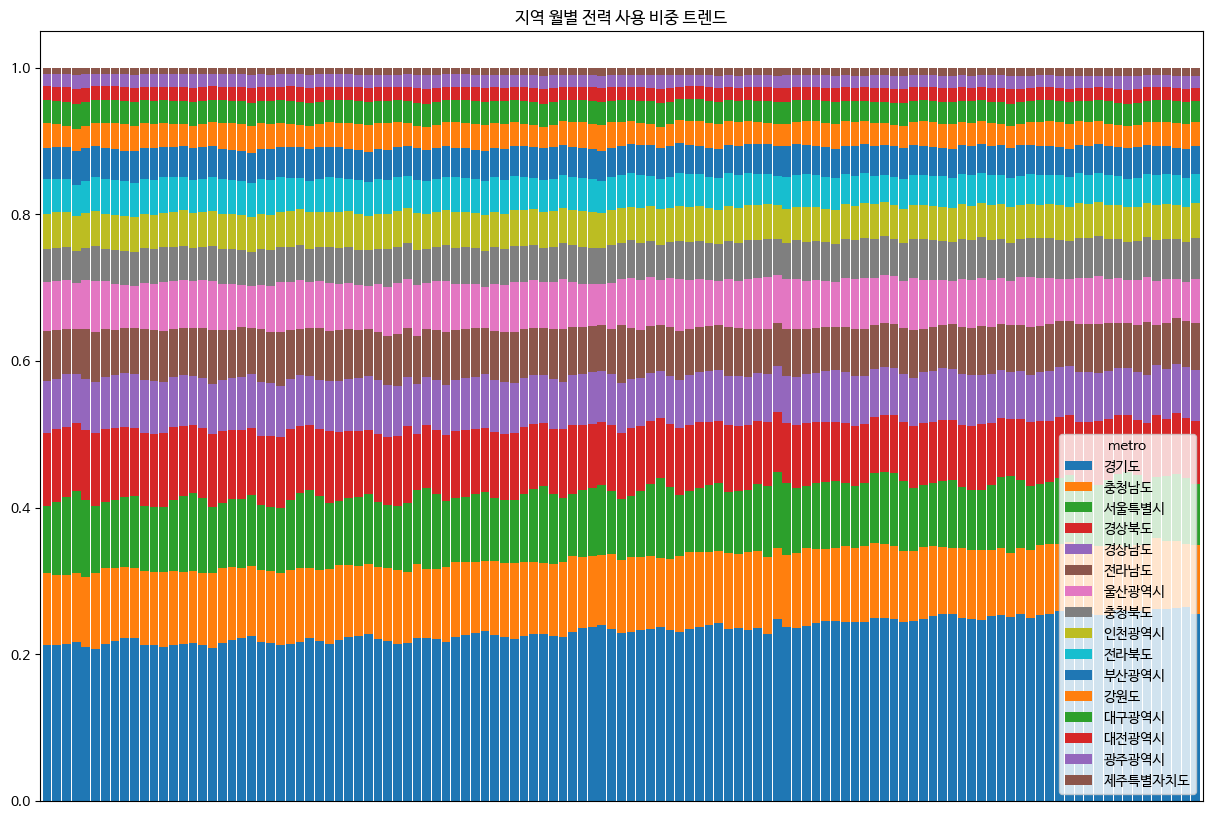

In [ ]:
## -----  3. 지역 전력 수요 비중을 기상 대표값의 가중치로 활용할 수 있음을 확인합니다. -----
def plot_power_usage_trend(dt):
    df = dt[['metro', 'TM', 'cntr', 'powerUsage']]
    df = df.groupby(['metro', 'TM']).agg({'powerUsage': 'sum'}).reset_index()

    df = pd.pivot_table(data=df, index='TM', columns='metro')
    df.columns = df.columns.droplevel(0)
    df['total'] = df.sum(axis=1)
    for col in df.columns:
        df[col] = df[col] / df['total']

    df.drop('total', axis=1, inplace=True)

    df = df.loc[:, df.sum().sort_values(ascending=False).index]
    df.plot.bar(stacked=True, figsize=(15, 10), width=0.9, xlabel='', xticks=[])
    plt.title('지역 월별 전력 사용 비중 트렌드')
    plt.show()

dt_1m = power_demand_type_1m_metro.groupby(['metro','TM','cntr']).sum().reset_index()
plot_power_usage_trend(dt_1m)


#### **B-2-b. 2013 - 2021 시간별 전력수요**

**1. 시간대별 전력수요는 명확한 패턴이 존재함을 확인합니다.**
>- 전체적으로 1차 최고 전력 수위는 18-19시, 2차 최고 전력 수위는 11시로 나타났습니다.
>     - 시간대가 중요한 변수로 활용될 수 있음을 확인합니다.
> **이전의 EDA와 동일하게, 특이 구간을 제외하면 전력수요는 우상향중입니다.**
>     - 2020, 2021년도 데이터는 코로나바이러스로 인해 전력수요가 감소한 것으로 추정됩니다.
>     - [2018년의 경우 여름 폭염](https://mobile.newsis.com/view.html?ar_id=NISX20180817_0000393464)으로 인한 냉방수요가 증가한 해로 높게 나오는 것으로 추정됩니다.

**2. 계절간의 시간대별 전력사용 패턴에 차이가 있음을 확인합니다.**
>- 여름, 겨울의 경우, 봄, 가을 대비 에너지 수요량의 변동폭이 높습니다.
>- 특히 여름의 경우 오전시간중 전력수요가 급격히 증가하는 경향이 보입니다.
>- 따라서 봄, 가을의 전력 수요 데이터가 안정적인 변화량을 띕니다.



2013 - 2021 연도별 전력수요

In [ ]:
rename_cols = dict(zip(data_power_demand_hour.columns[1:25].tolist(), [i+1 for i in range(24)]))
data_power_demand_hour.rename(columns=rename_cols, inplace=True)

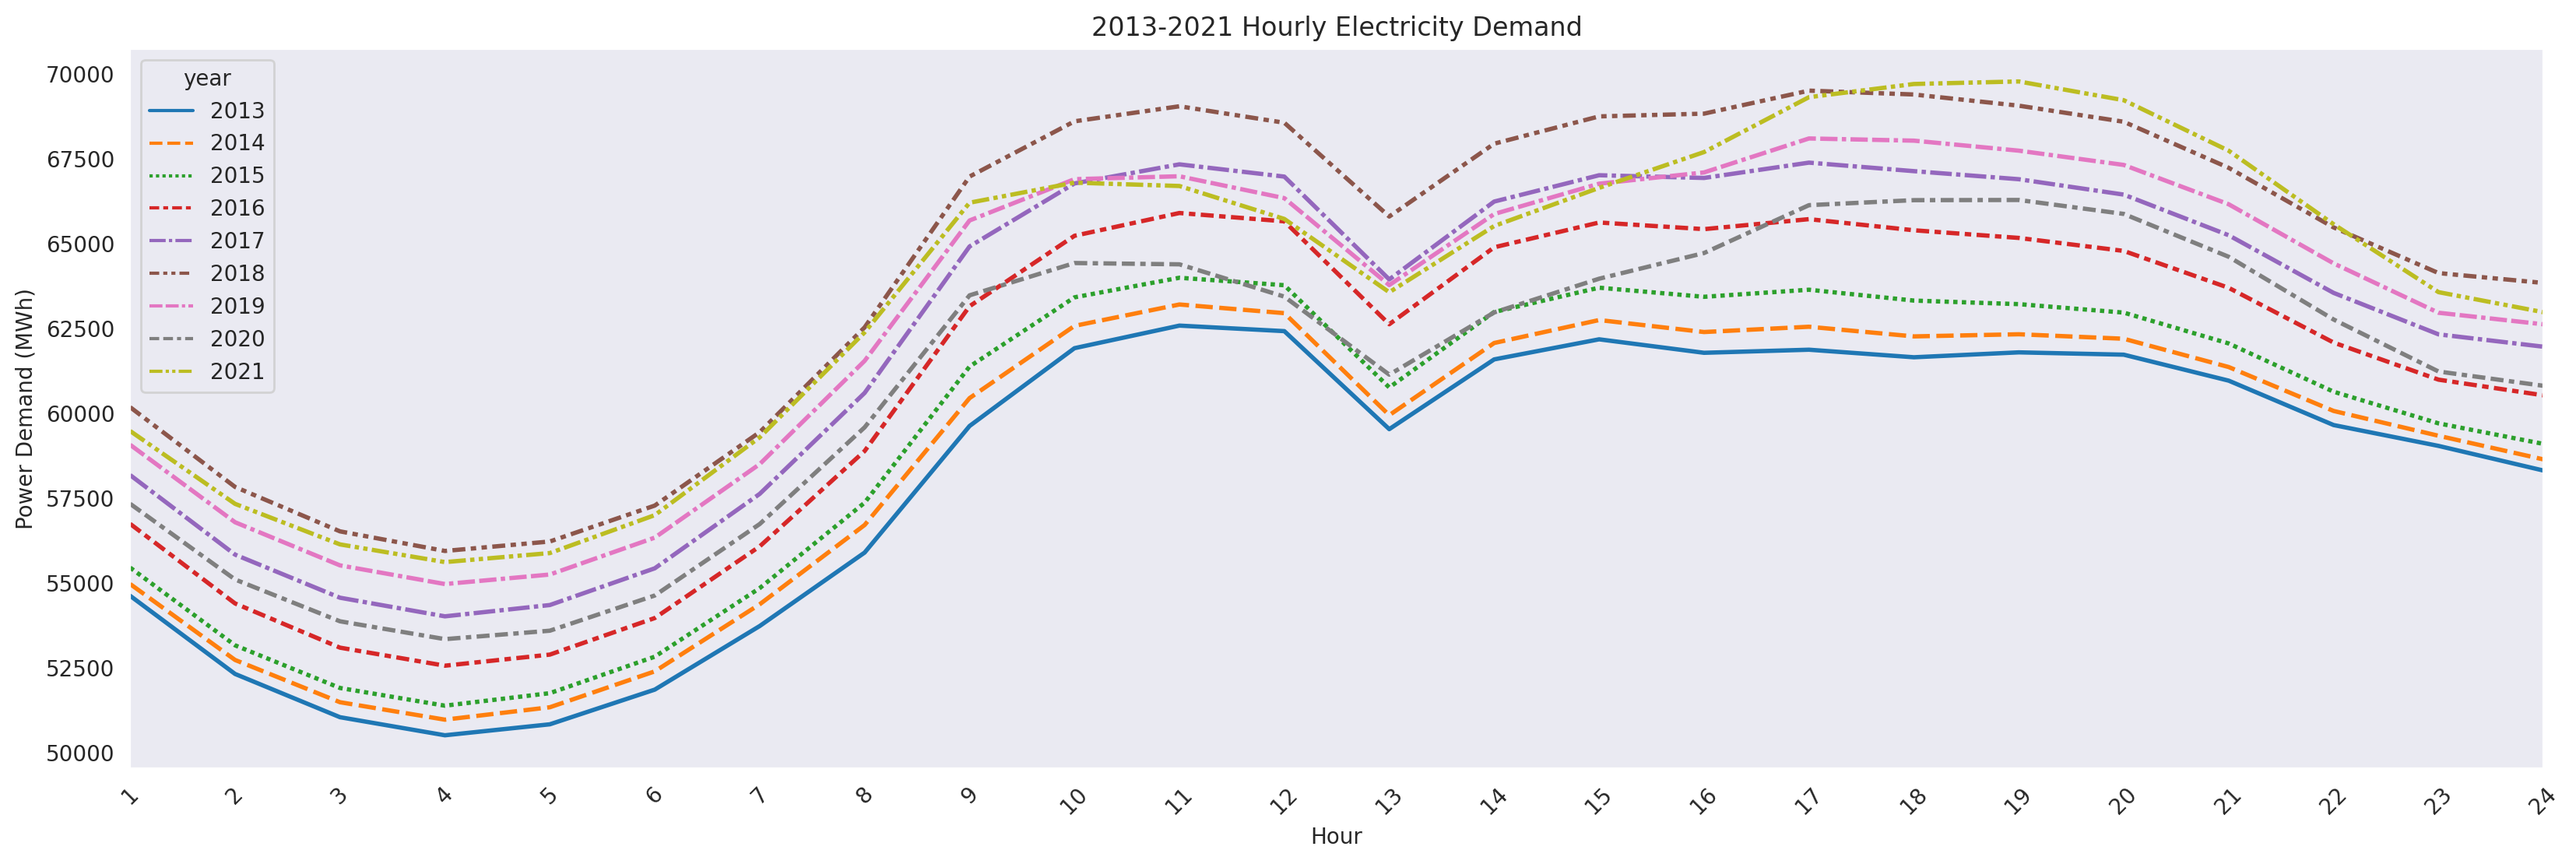

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data_power_demand_hour.drop('날짜', axis=1).groupby(['year']).mean().T, lw=2)
plt.title('2013-2021 Hourly Electricity Demand') # 2013-2021 시간별 전력수요
plt.xticks([i+1 for i in range(24)], rotation=45)
plt.xlabel('Hour')
plt.ylabel('Power Demand (MWh)') # 전력수요량(MWh)
plt.xlim([1,24])
plt.grid()
plt.show()

2013 - 2021 계절별 전력수요

In [ ]:
data_power_demand_hour['날짜'] = pd.to_datetime(data_power_demand_hour['날짜'])

In [ ]:
data_power_demand_hour['year'] = 0
data_power_demand_hour['year'][(data_power_demand_hour['날짜'].dt.month == 3) | (data_power_demand_hour['날짜'].dt.month == 4) | (data_power_demand_hour['날짜'].dt.month == 5)] = 'Spring' # 봄
data_power_demand_hour['year'][(data_power_demand_hour['날짜'].dt.month == 6) | (data_power_demand_hour['날짜'].dt.month == 7) | (data_power_demand_hour['날짜'].dt.month == 8)] = 'Summer' # 여름
data_power_demand_hour['year'][(data_power_demand_hour['날짜'].dt.month == 9) | (data_power_demand_hour['날짜'].dt.month == 10) | (data_power_demand_hour['날짜'].dt.month == 11)] = 'Fall' # 가을
data_power_demand_hour['year'][(data_power_demand_hour['날짜'].dt.month == 12) | (data_power_demand_hour['날짜'].dt.month == 1) | (data_power_demand_hour['날짜'].dt.month == 2)] = 'Winter' # 겨울
data_power_demand_hour['날짜'] = data_power_demand_hour['날짜'].astype('str')
data_power_demand_hour.rename(columns={'year' : 'season'}, inplace=True)

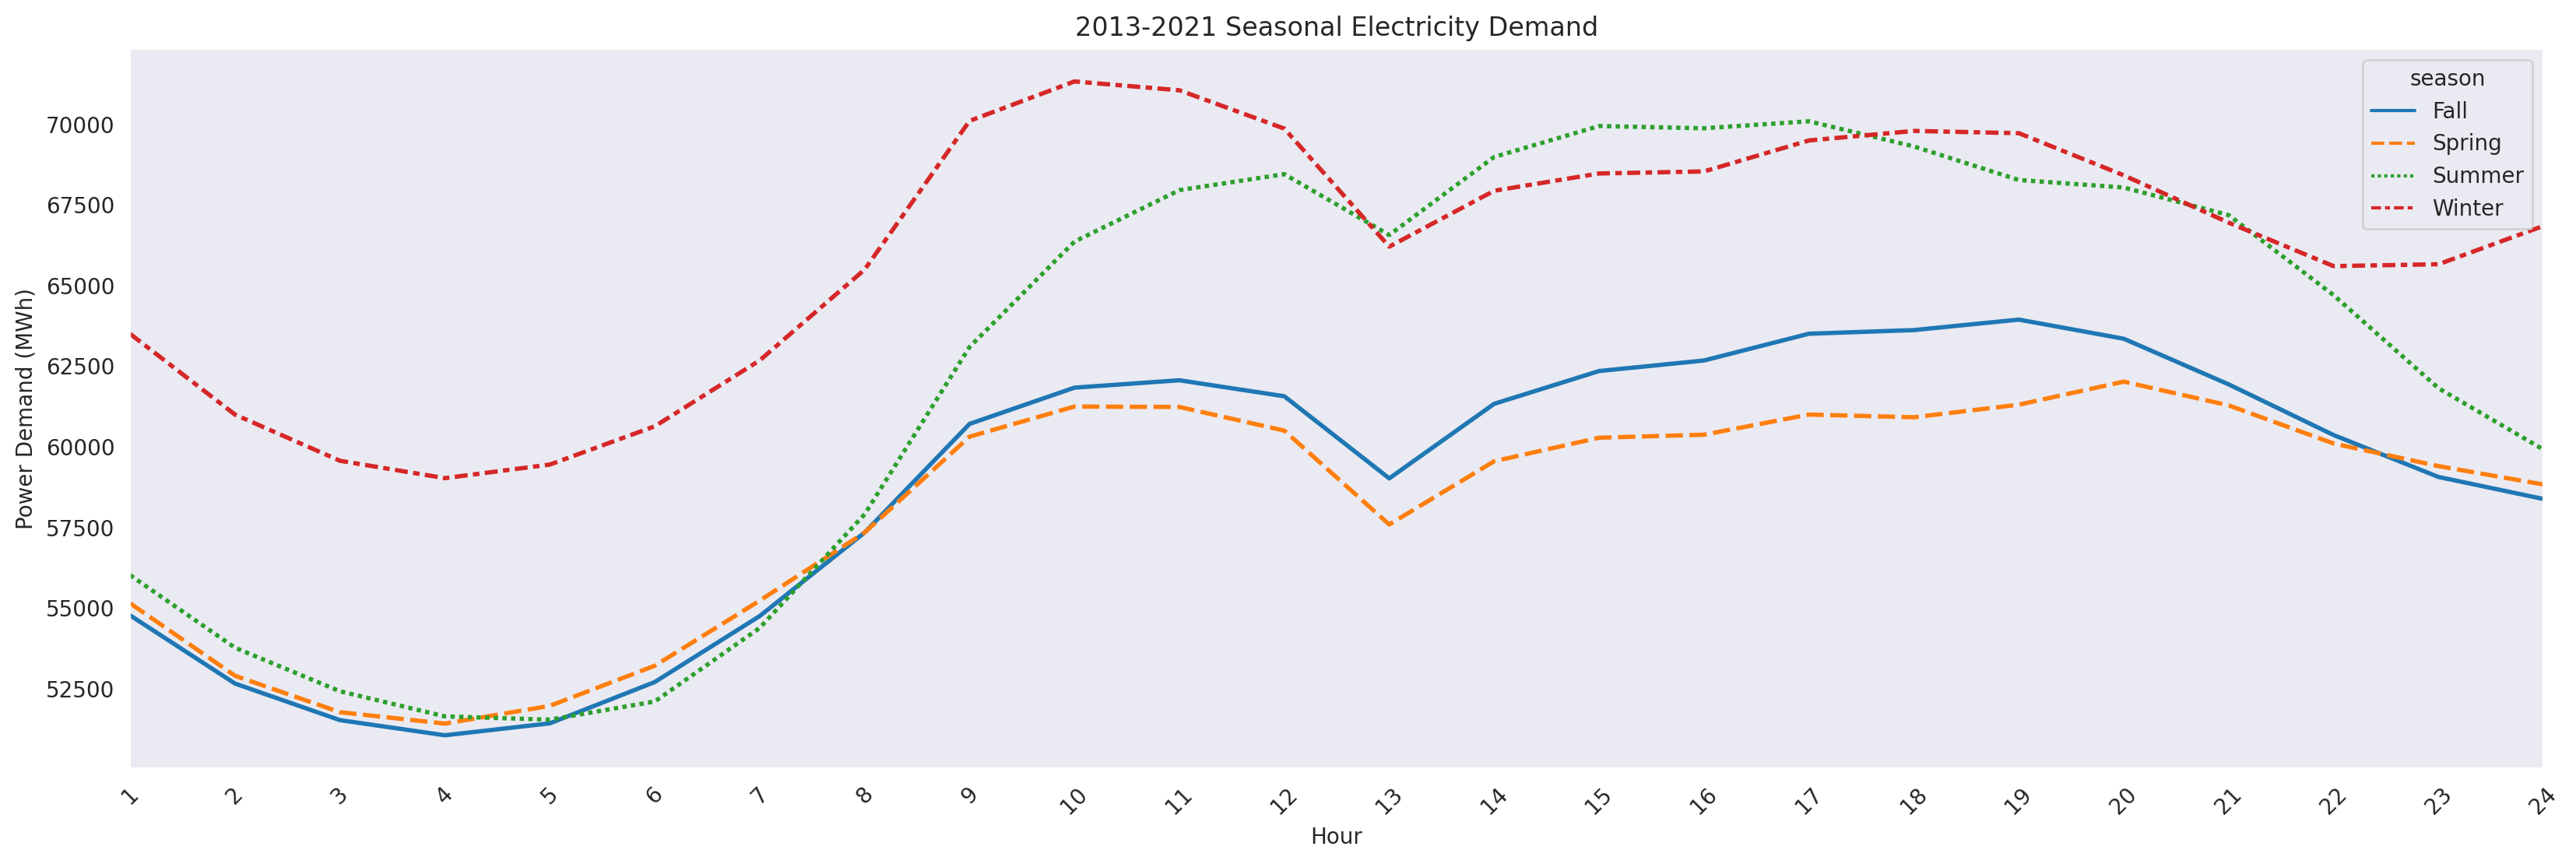

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data_power_demand_hour.drop('날짜', axis=1).groupby(['season']).mean().T, lw=2)
plt.title('2013-2021 Seasonal Electricity Demand') # 2013-2021 계절별 전력수요
plt.xticks(rotation=45)
plt.xlabel('Hour')
plt.ylabel('Power Demand (MWh)') # 전력수요량(MWh)
plt.xticks([i+1 for i in range(24)])
plt.xlim([1, 24])
plt.grid()
plt.show()

#### **B-2-c. 연도별 요일에 따른 시간 평균 전력수요 변화**

**1. 요일별 전력 수요량에는 명확한 패턴이 확인됩니다.**
>- 각 요일별 평균 시간당 전력수요를 바탕으로, 월, 화-금, 토, 일로 구분되는 패턴을 확인합니다.
>- 이전의 EDA 인사이트와 동일하게, 2019, 2020년의 추세 이탈은 코로나의 영향으로 추측됩니다.
>- 시간대와 마찬가지로, 요일과 주말의 유무 변수 역시 중요한 변수로 활용될 수 있음을 확인합니다.

In [ ]:
data_power_demand_hour['날짜'] = pd.to_datetime(data_power_demand_hour['날짜'])
data_power_demand_hour['year'] = data_power_demand_hour['날짜'].dt.year
data_power_demand_hour['weekday'] = data_power_demand_hour['날짜'].dt.weekday
test = data_power_demand_hour.groupby(['year', 'weekday']).mean()
test = pd.DataFrame(test.T.sum()).reset_index()
test.columns = ['year', 'weekday', 'demand']
test['demand'] = test['demand'] / 24

In [ ]:
weekday_dict = {0 : 'Monday', 1 : 'Tuesday', 2 : 'Wednesday', 3 : 'Thursday', 4 : 'Friday', 5 : 'Saturday', 6 : 'Sunday'}
def weekday(data):
    return weekday_dict[data]
test['weekday'] = test['weekday'].apply(weekday)

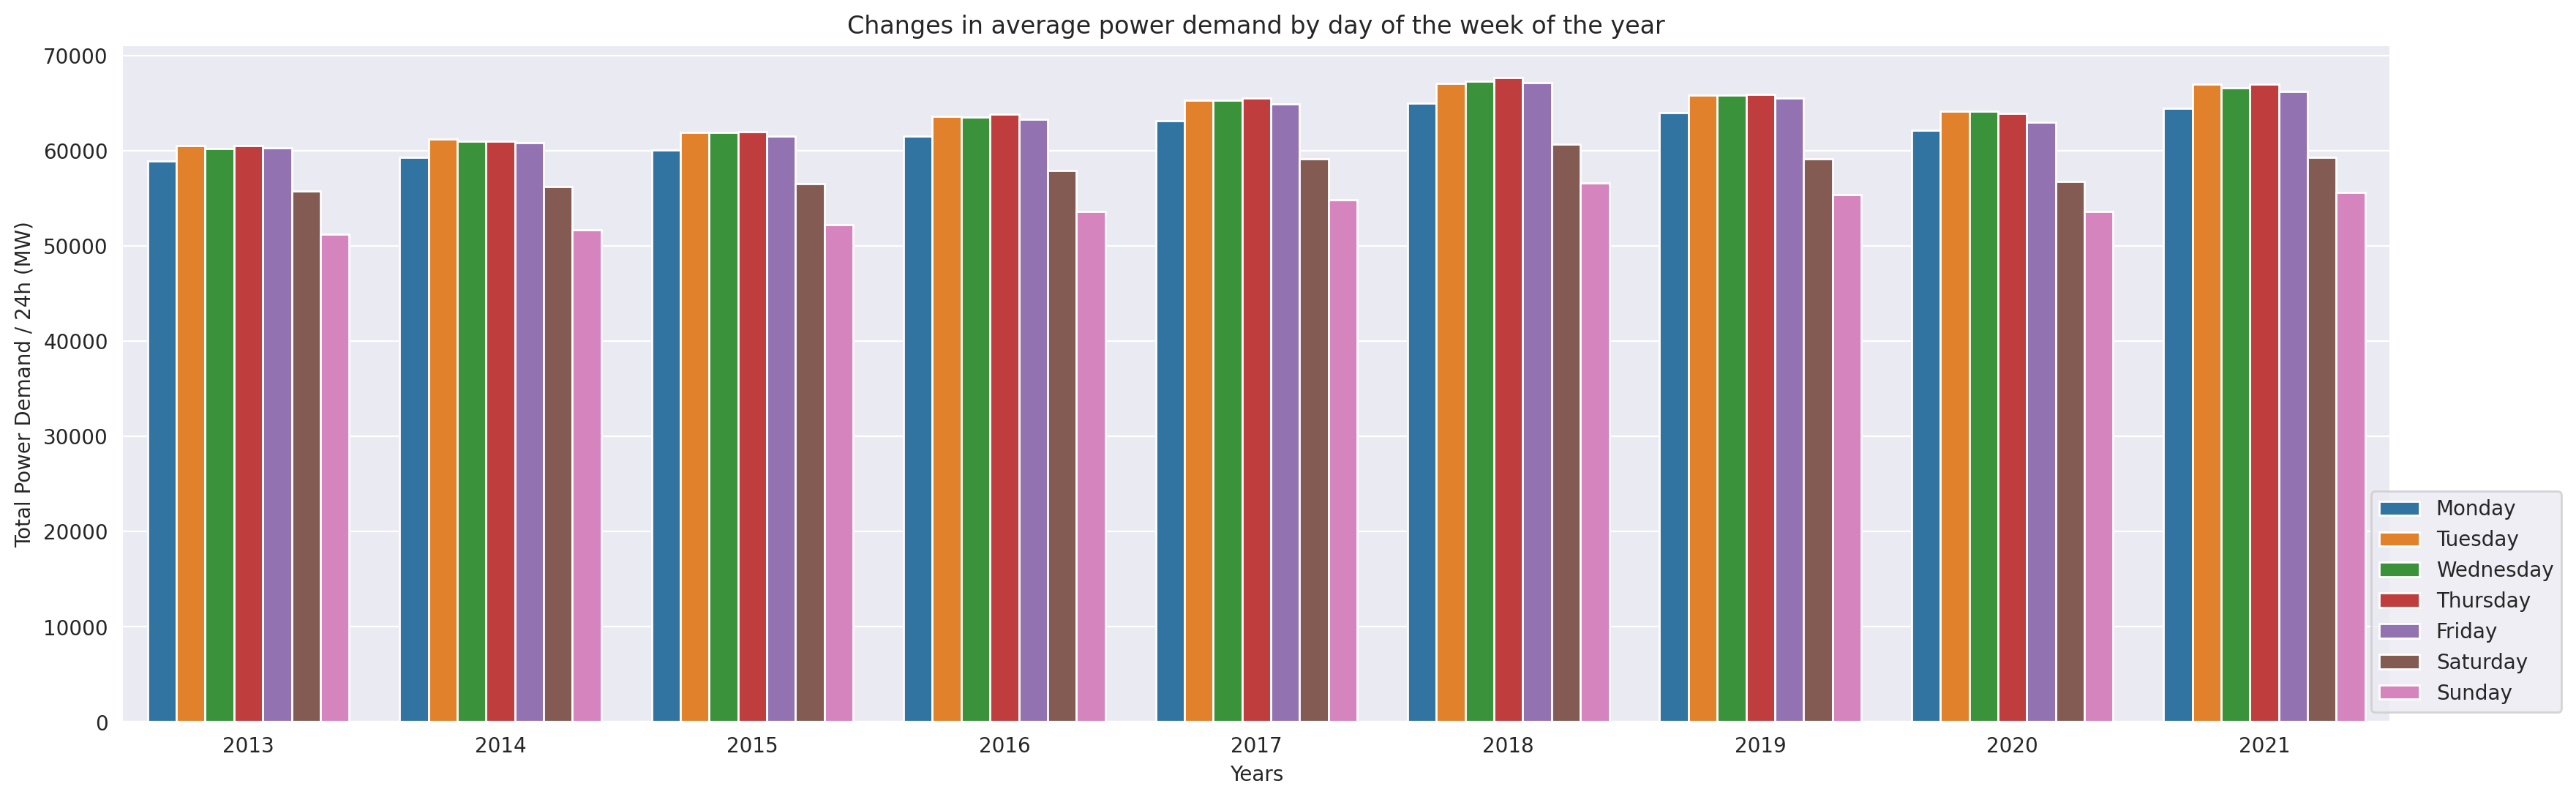

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(data=test, x='year', y='demand', hue='weekday',  errorbar=None)
plt.legend(loc='lower right', bbox_to_anchor = (1.08, 0))
plt.grid()
plt.title('Changes in average power demand by day of the week of the year') # 년도별 요일에 따른 시간 평균 전력수요 변화
plt.xlabel('Years')
plt.ylabel('Total Power Demand / 24h (MW)')
plt.grid()
plt.show()

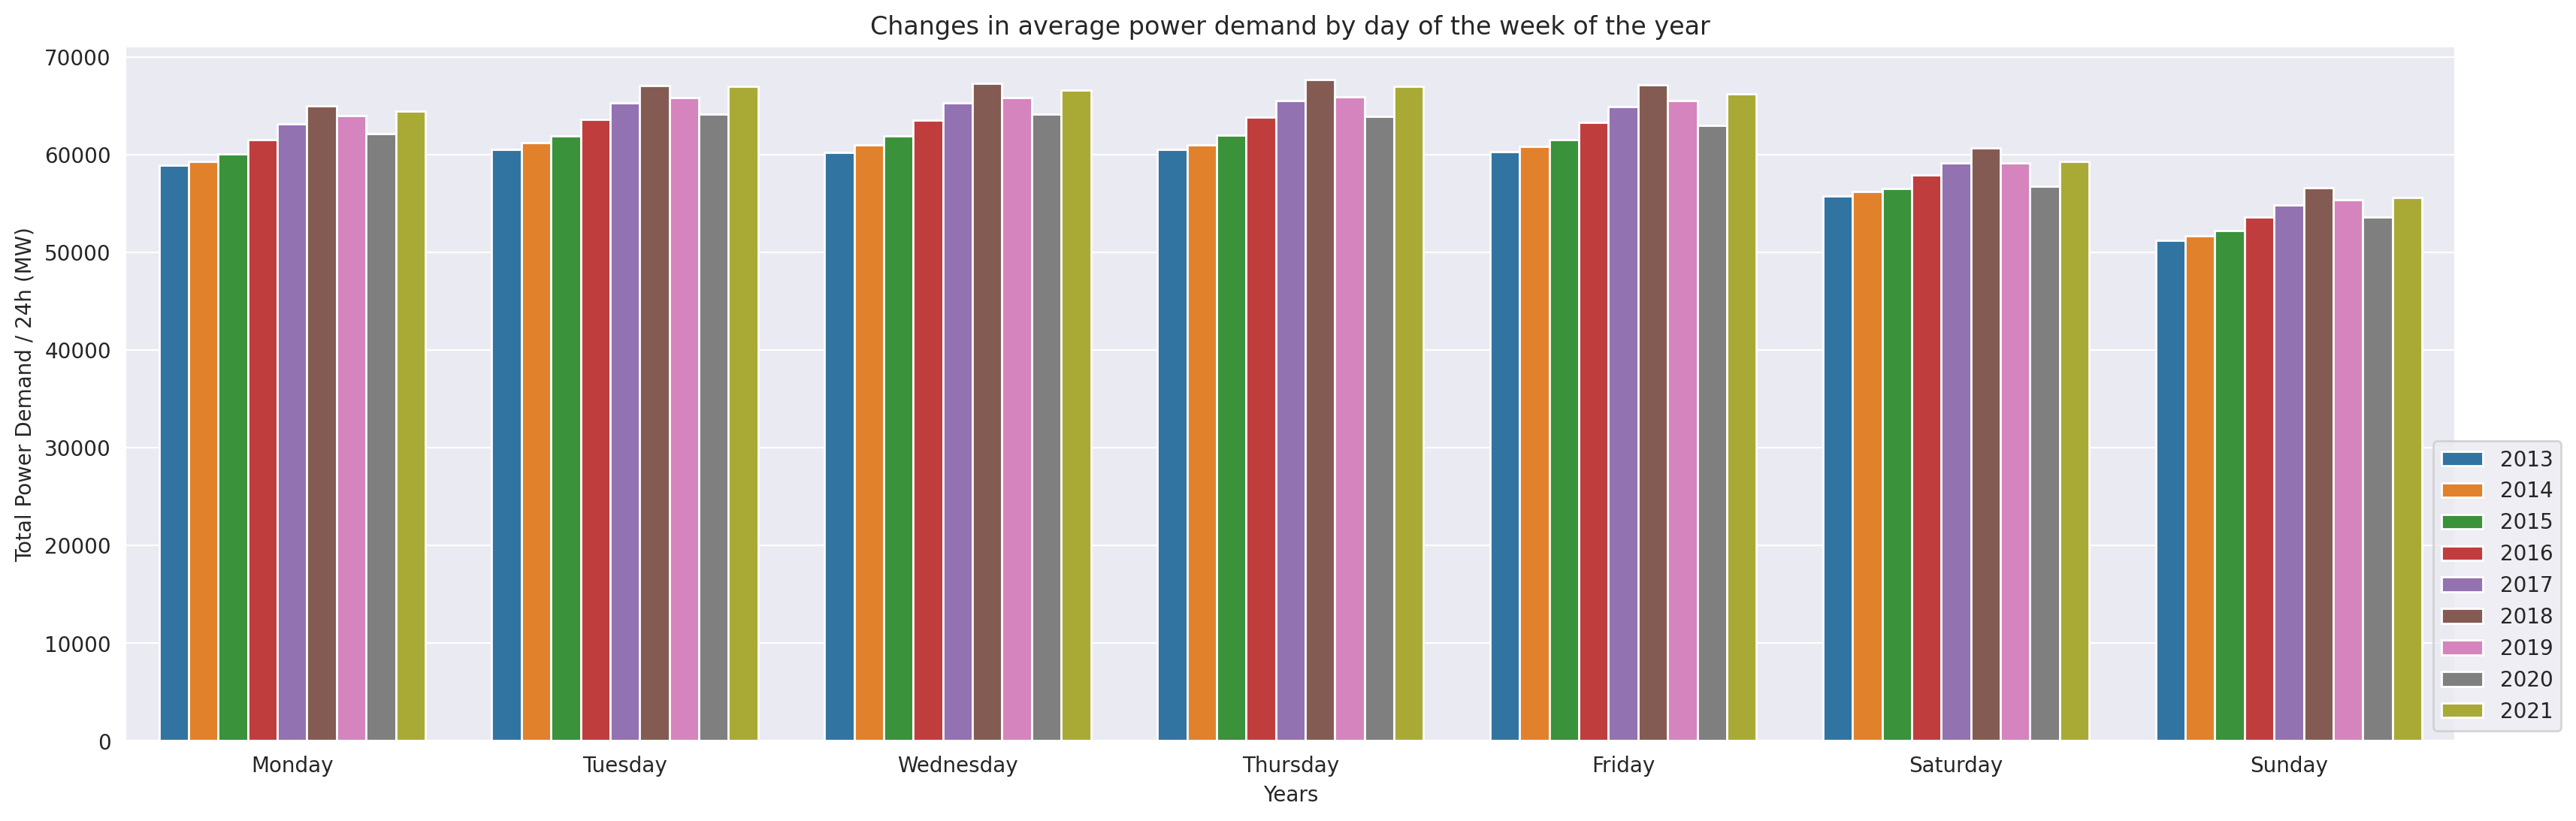

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(data=test, x='weekday', y='demand', hue='year',  errorbar=None)
plt.legend(loc='lower right', bbox_to_anchor = (1.05, 0))
plt.grid()
plt.title('Changes in average power demand by day of the week of the year') # 년도별 요일에 따른 시간 평균 전력수요 변화
plt.xlabel('Years')
plt.ylabel('Total Power Demand / 24h (MW)')
plt.grid()
plt.show()

In [ ]:
del test, data_power_demand_hour

### **B-3. 태양광 데이터 트렌드 EDA**
**1. 전력 수요 예측에 있어, 태양광 데이터의 중요성은 점점 커지고 있습니다.**
>- 온실가스 배출 감축 목표가 강제됨에 따라 증가한 신재생에너지 발전량은 전력시장에 큰 영향을 미칩니다.
>- [2022년, 신재생 발전설비 비중이 전체의 20%를 달성했고](https://www.koscaj.com/news/articleView.html?idxno=229710), 그 중 태양광 발전은 15%를 상회하는 비중을 차지합니다.
>- 따라서, 태양광 데이터의 추이를 살피고, 전력수요 예측 모델의 성능을 높이기 위해 활용할 수 있는 변수를 찾습니다.

**2. 단, 태양광 발전량 측정 이슈로 데이터 활용에 애로사항이 있습니다.**
>- 국내 태양광 발전의 대부분은 1MW 이하의 소용량 발전기로, 발전량이 실시간으로 집계되지 않습니다. 
>- 이를 BTM 태양광 발전설비라 부르며, 아래 2,3번에 해당합니다.
>     1. 1MW 초과 설비 용량 & 전력 시장 이용 : 태양광 발전 설비
>     2. 1MW 이하 설비 용량 & 전력 시장 이용 : PPA 발전 설비
>     3. 1MW 이하 설비 용량 & 전력 시장 미이용 : 기타 발전 설비
>- 3번, 기타 발전 설비량의 경우 실시간 전력 발전량 뿐 아니라, 전체 발전량이 집계되지 않기에 추정이 필요합니다. 
>- 다만, 이를 위한 일사, 일조량의 결측량과 기타 데이터의 부족으로 정확한 추정이 어렵습니다.

**3. 따라서 1,2번 데이터를 살펴 얻은 인사이트를 태양광 발전과 상관도가 높은 일사량 변수에 적용합니다.**
>1. PPA 발전 설비의 경우, 설비용량과 사업자수 모두 증가하는 추세를 보입니다.
>    - 2013년부터 증가가 시작되었고, 2018년 이후 급격한 증가세를 보입니다.
>2. 한국전력거래소 월별 태양광 전력거래량의 경우, 최근 데이터 일수록 태양광 전력거래량은 증가하는 추세입니다,
    - 2018년을 제외한 각 년도별 피크값은 일사량이 높은 봄-초여름에 발생했습니다.
    - 봄-초여름에 일사량이 크게 증가하므로, 태양광 에너지의 영향을 일사량 변수에 확장할 수 있음을 확인합니다.


*여름엔 온도가 높아 태양광 셀의 발전효율이 저하되기 때문에, 봄에 발전시간이 가장 김*

In [ ]:
sns.set_style('darkgrid')
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:

data_ppa = pd.read_csv(PATH + '한국전력공사_발전원별 PPA 계약현황_20201008.csv', encoding='euckr')
data_renewable = pd.read_csv(PATH + '한국전력거래소_신재생에너지 전력거래량_20211201.csv', encoding='euckr')
data_power_demand_hour = pd.read_csv(PATH + '시간별 전력수요량 2013-2021.csv')
WEATHER_5MIN = pd.read_parquet(PATH + 'weather_5minute_ASOS_2020-2023.parquet')
NET_LOAD = pd.read_csv(PATH + '한국전력거래소_5분단위 전력수급현황_20120601_20230320.csv')
STATION = pd.read_csv(PATH + 'weather_tmp.csv')

[Errno 2] No such file or directory: '/content/drive/MyDrive/DL Project/data'
/content


In [ ]:
SC_PPA = data_ppa.copy()
SC_PPA = SC_PPA[SC_PPA['발전원'] == '태양광']
KPXSG = data_renewable.copy()
KPXSG = pd.DataFrame(KPXSG[['기간', '(재생에너지)태양']])
KPXSG['기간'] = pd.to_datetime(KPXSG['기간'])
KPXSG['background'] = 0
KPXSG['background'][(KPXSG['기간'].dt.month == 3) | (KPXSG['기간'].dt.month == 4) | (KPXSG['기간'].dt.month == 5)] = 'Spring' # 봄
KPXSG['background'][(KPXSG['기간'].dt.month == 6) | (KPXSG['기간'].dt.month == 7) | (KPXSG['기간'].dt.month == 8)] = 'Summer' # 여름
KPXSG['background'][(KPXSG['기간'].dt.month == 9) | (KPXSG['기간'].dt.month == 10) | (KPXSG['기간'].dt.month == 11)] = 'Fall' # 가을
KPXSG['background'][(KPXSG['기간'].dt.month == 12) | (KPXSG['기간'].dt.month == 1) | (KPXSG['기간'].dt.month == 2)] = 'Winter' # 겨울
KPXSG['기간'] = KPXSG['기간'].astype('str')
data_power_demand_hour['날짜'] = pd.to_datetime(data_power_demand_hour['날짜'])
data_power_demand_hour['year'] = data_power_demand_hour['날짜'].dt.year
data_power_demand_hour['year'] = data_power_demand_hour['year'].astype('int')

del data_ppa

#### **B-3-a. 한국전력공사 PPA 태양광 발전 계약현황**
>- PPA 발전 설비의 경우, 설비용량과 사업자수 모두 증가하는 추세를 보입니다.
>- 2013년부터 증가가 시작되었고, 2018년 이후 급격한 증가세를 보입니다.

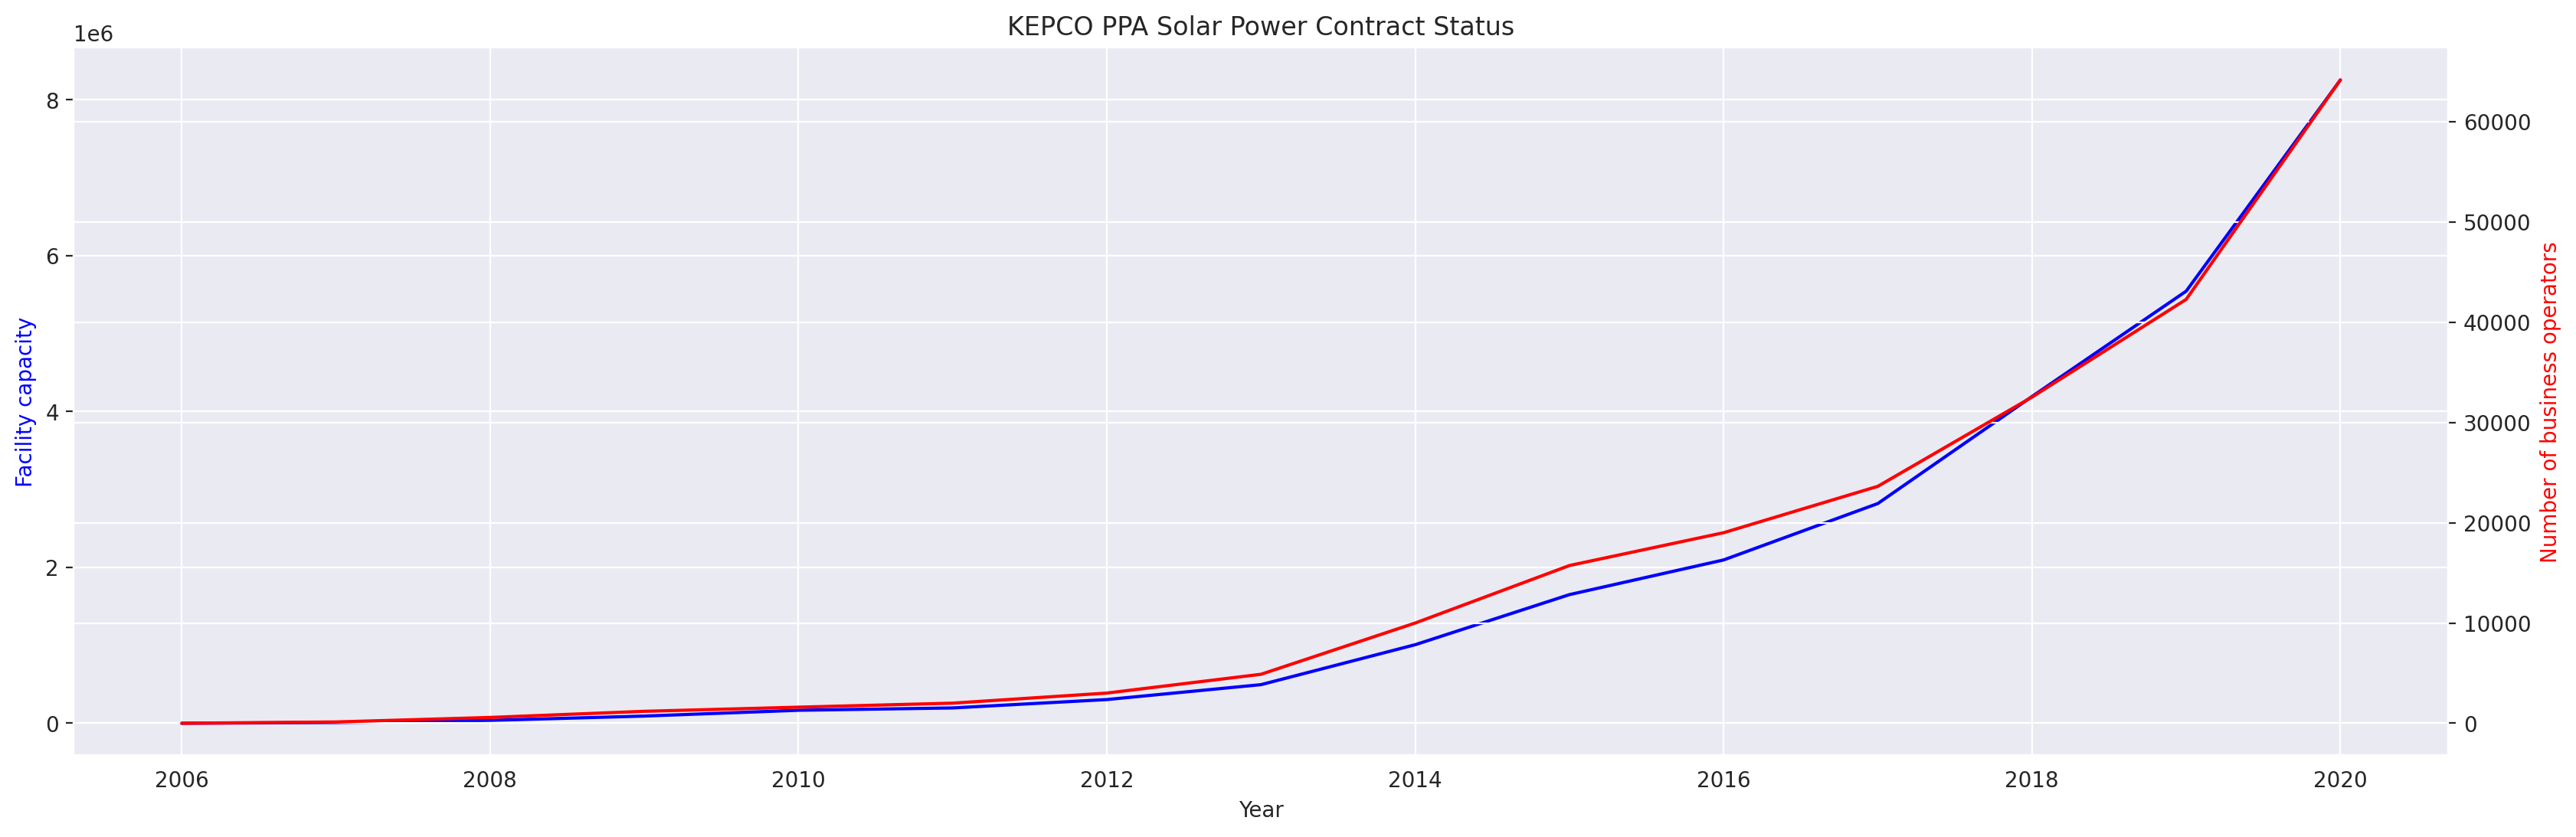

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.title('KEPCO PPA Solar Power Contract Status') # 한국전력공사 PPA 태양광 발전 계약현황
ax2 = ax.twinx()
sns.lineplot(data=SC_PPA, x='년도', y='설비용량', ax=ax, color='b')
sns.lineplot(data=SC_PPA, x='년도', y='사업자수', ax=ax2, color='r')
ax.set_ylabel('Facility capacity', color='b') # 설비용량
ax2.set_ylabel('Number of business operators', color='r') # 사업자수
ax.set_xlabel('Year')
ax2.set_xlabel('Year')

plt.show()

In [ ]:
del SC_PPA

#### **B-3-b. 한국전력거래소 월별 태양광 전력거래량 2017 - 2021**
한국전력거래소 월별 태양광 전력거래량의 경우, 최근 데이터 일수록 태양광 전력거래량은 증가하는 추세입니다,
>  - 2018년을 제외한 각 년도별 피크값은 여름에 발생했습니다.
>  - 여름에 일사량이 크게 증가하므로, 태양광 에너지의 영향을 일사량 변수에 확장할 수 있음을 확인합니다.

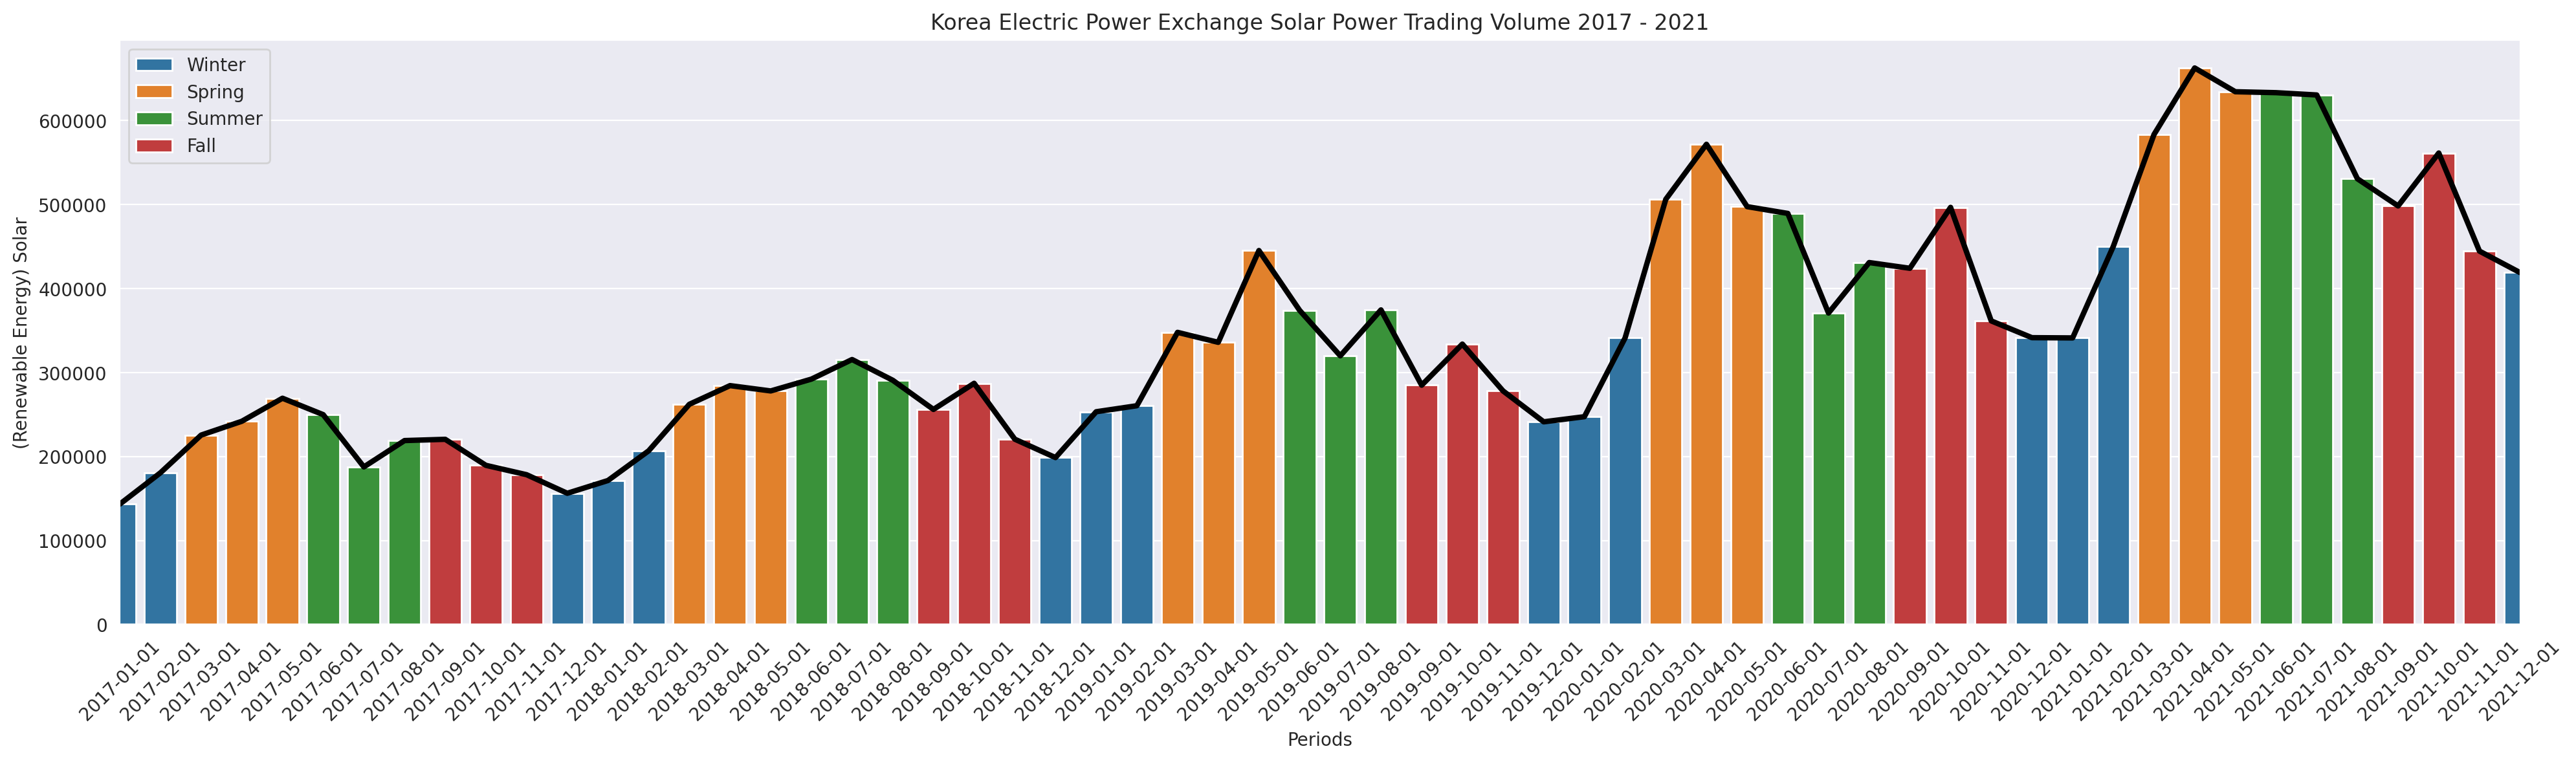

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(data=KPXSG, x='기간', y='(재생에너지)태양', hue='background', dodge=False)
sns.lineplot(data=KPXSG, x='기간', y='(재생에너지)태양', lw=3, color='black')
plt.title('Korea Electric Power Exchange Solar Power Trading Volume 2017 - 2021') # 한국전력거래소 태양광 전력거래량 2017 - 2021
plt.xlabel('Periods') # 기간
plt.ylabel('(Renewable Energy) Solar') # (재생에너지)태양
plt.xticks(rotation=45)
plt.xlim([('2017-01-01'), ('2021-12-01')])
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

- **최근 데이터 일수록 태양광 전력거래량은 증가하는 추세**
- **2018년을 제외한 각 년도별 피크값은 봄에 발생**

In [ ]:
del KPXSG

### **B-4. 기상 데이터 EDA**
**1. 기상 대표값을 도출하여 기상관측장비로 인한 결측 이슈를 극복해야함을 확인합니다.**
>- 강수량, 풍향, 일사, 일조 변수에서 많은 결측값이 발견되었습니다.
>- 관측소 기기별 정기적인 점등, 지역별 기기 이슈 등으로 추측됩니다.
>- 전국 평균, 전국 최대 최소, 지역별 가중치를 활용한 가중평균을 고려합니다.

**2. 기온 정보와 에너지 전력 수요간의 상관성을 확인합니다.**
>- 기온, 지면 온도, 이슬점 온도, 수증기압 데이터가 전력 수요와 양극단에서의 상관관계를 발견할 수 있습니다.
>- 지면 온도, 이슬점 온도, 수증기압 모두 기온의 후행지표이며, 기온의 산포도가 가장 명확하므로 기온을 중요 인자로 선정할 수 있습니다.
>- 기상 대표값 선정에, 기온의 최대 최저 값을 활용할 수 있음을 확인합니다.

**3. 일사량과 에너지 전력 수요간의 상관성을 확인합니다.**
>- 5분 간격의 데이터를 1주 이동 중앙값으로 산출하여 기온,일사량과 전력수요간의 상관 관계를 확인했습니다.
>- 기온과 에너지 수요의 경우, 명확하게 겹치는 게절성이 확인되었습니다.
>- 일사량과 에너지 수요의 경우, 기온 데이터 대비 계절성의 분명함은 덜했으나, 에너지 수요와의 상관관계가 약1.7배임을 확인합니다.
>- 이는 기온데이터 중 가장 높은 상관관계입니다.
>- 다만 노이즈가 상당하여, 상관관계에 노이즈가 많음을 확인합니다.



#### **B-4-a. 각 기상인자별 분포 및 결측값 확인**
기상 대표값을 도출하여 기상관측장비로 인한 결측 이슈를 극복해야함을 확인합니다.



In [ ]:
plot_data = WEATHER_5MIN.drop(['지점', '일시'], axis=1)

<ipython-input-9-dc0193c96164>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_data[plot_data.columns[i]], bins=100)
<ipython-input-9-dc0193c96164>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plot_data[plot_data.columns[i]], bins=100)
<ipython-input-9-dc0193c96164>:7: UserWarning: 

`

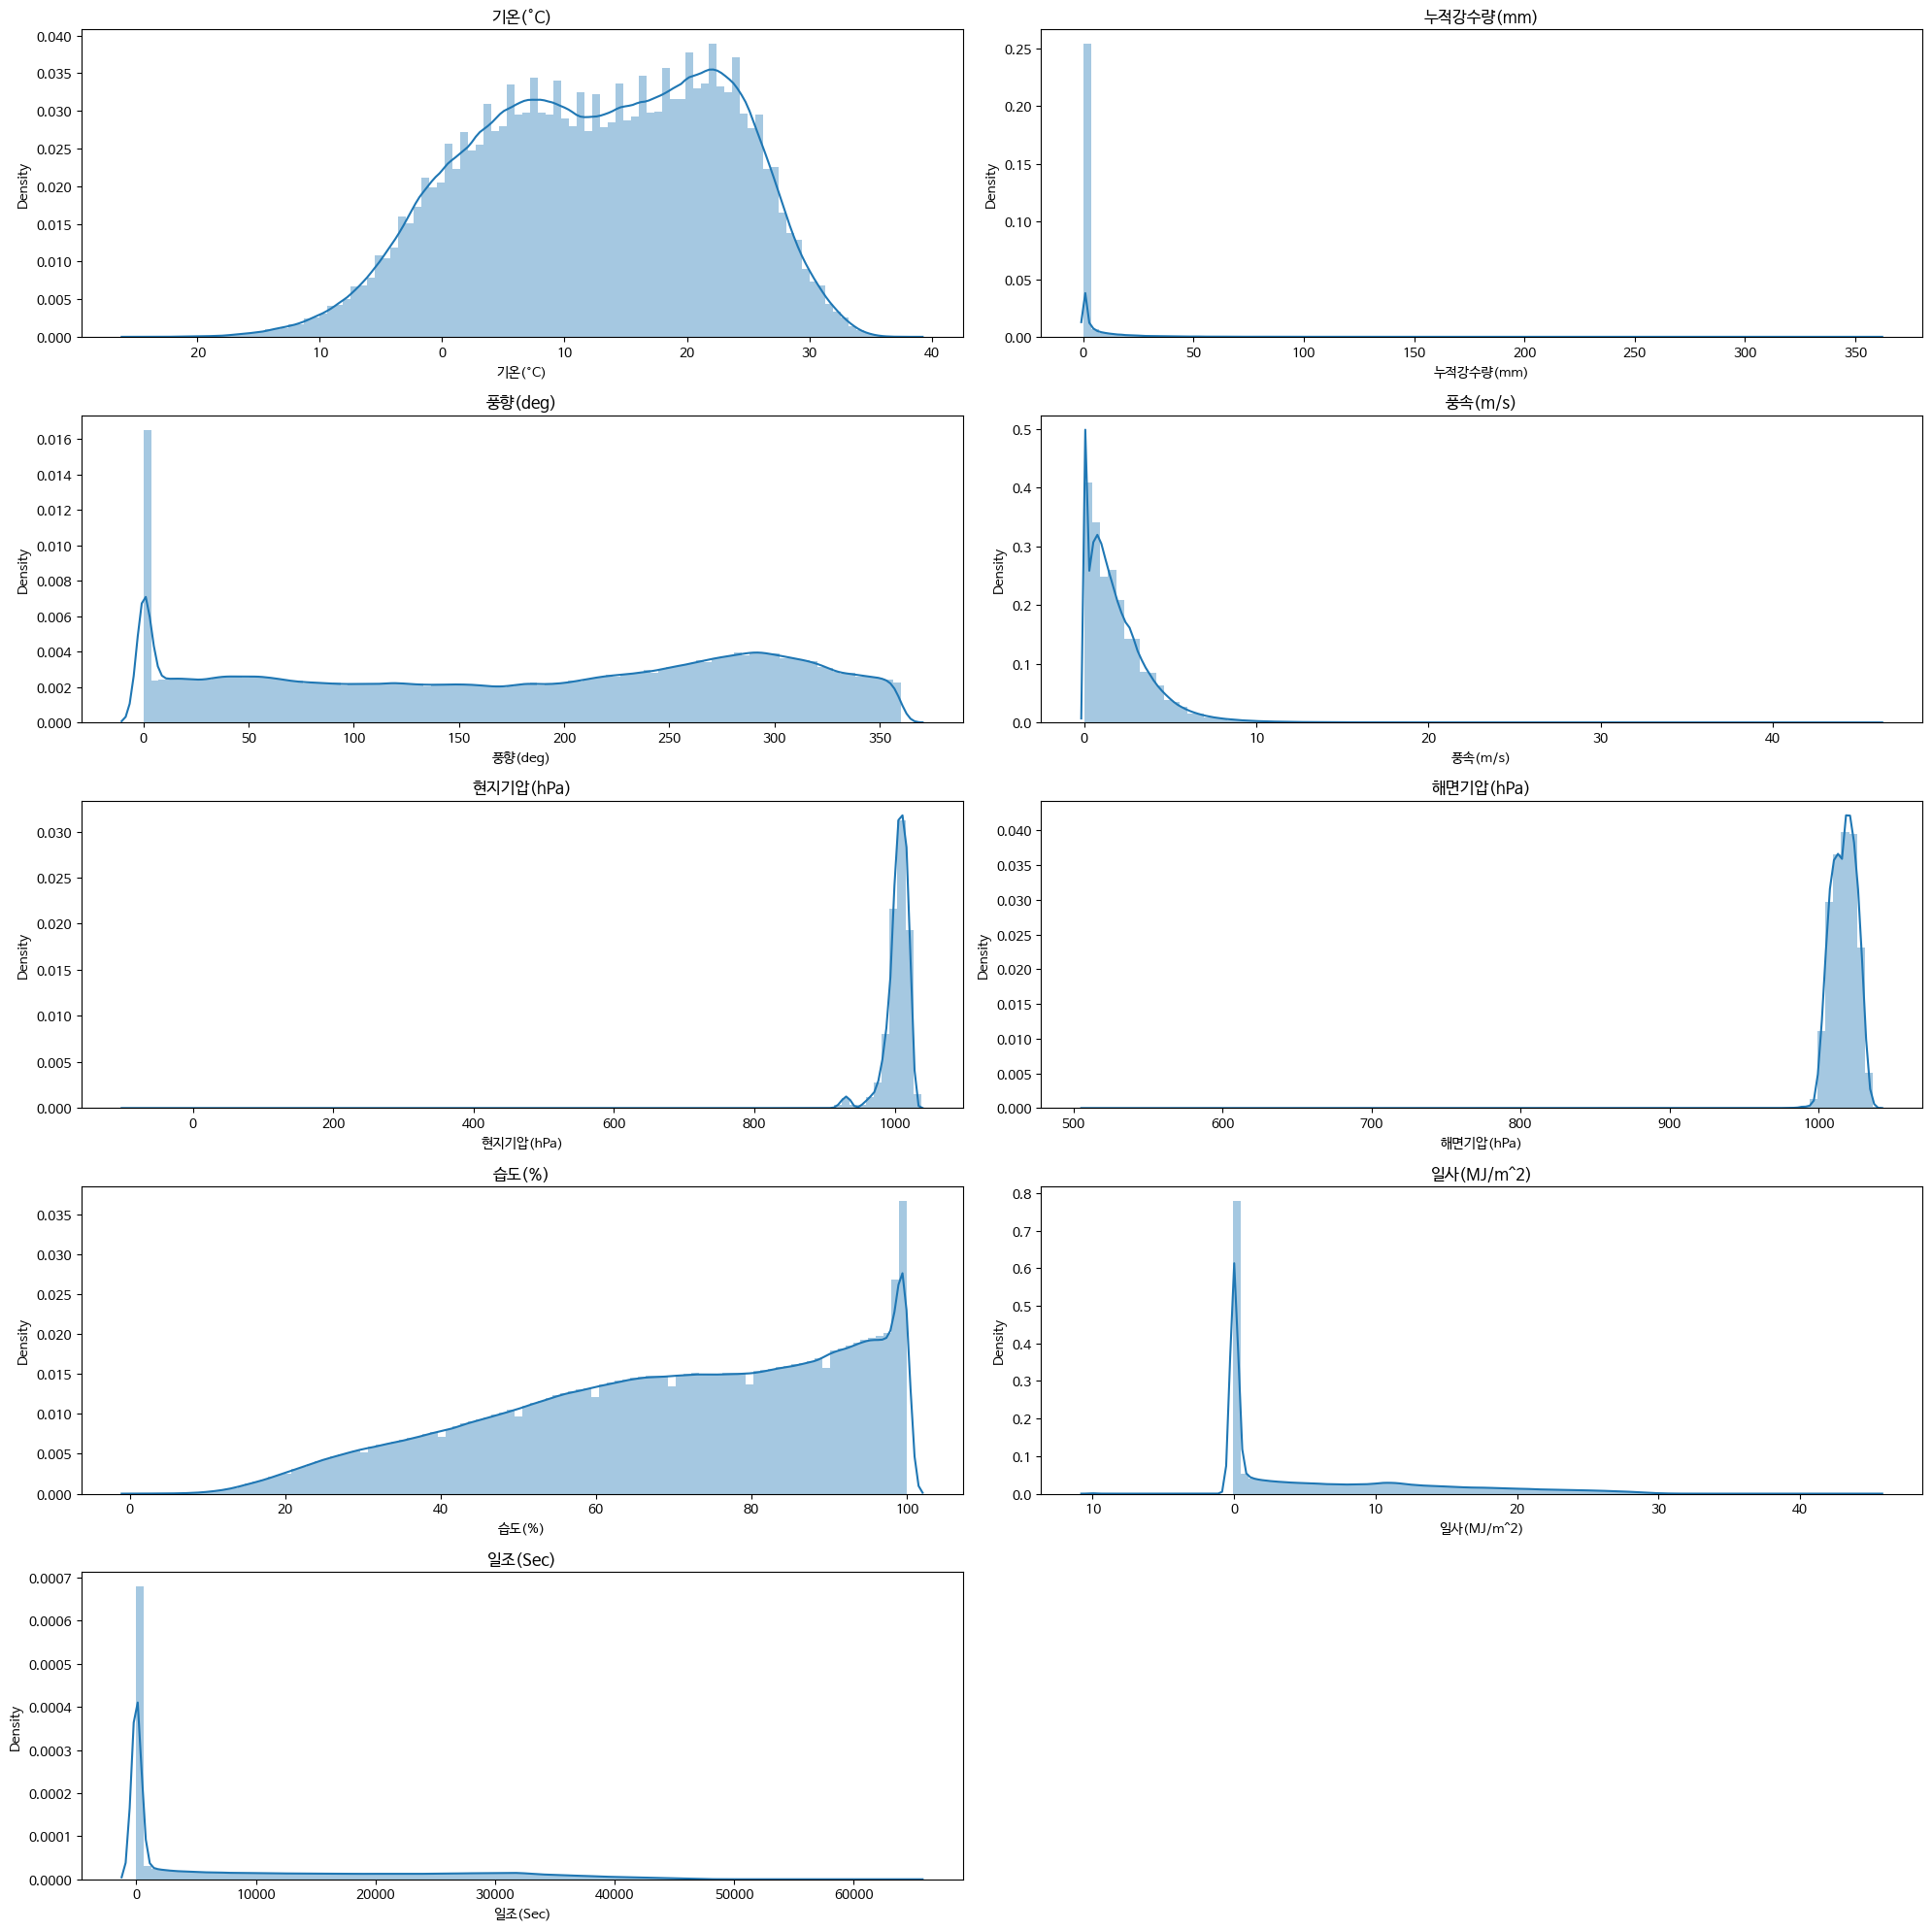

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(len(plot_data.columns)):
    plt.subplot(521+(i))
    sns.distplot(plot_data[plot_data.columns[i]], bins=100)
    plt.title(plot_data.columns[i])

plt.tight_layout()
plt.show()

#### **B-4-b. 기상 온도 데이터와 에너지 전력 수요간의 상관성**
기온 정보와 에너지 전력 수요간의 상관성을 확인합니다.

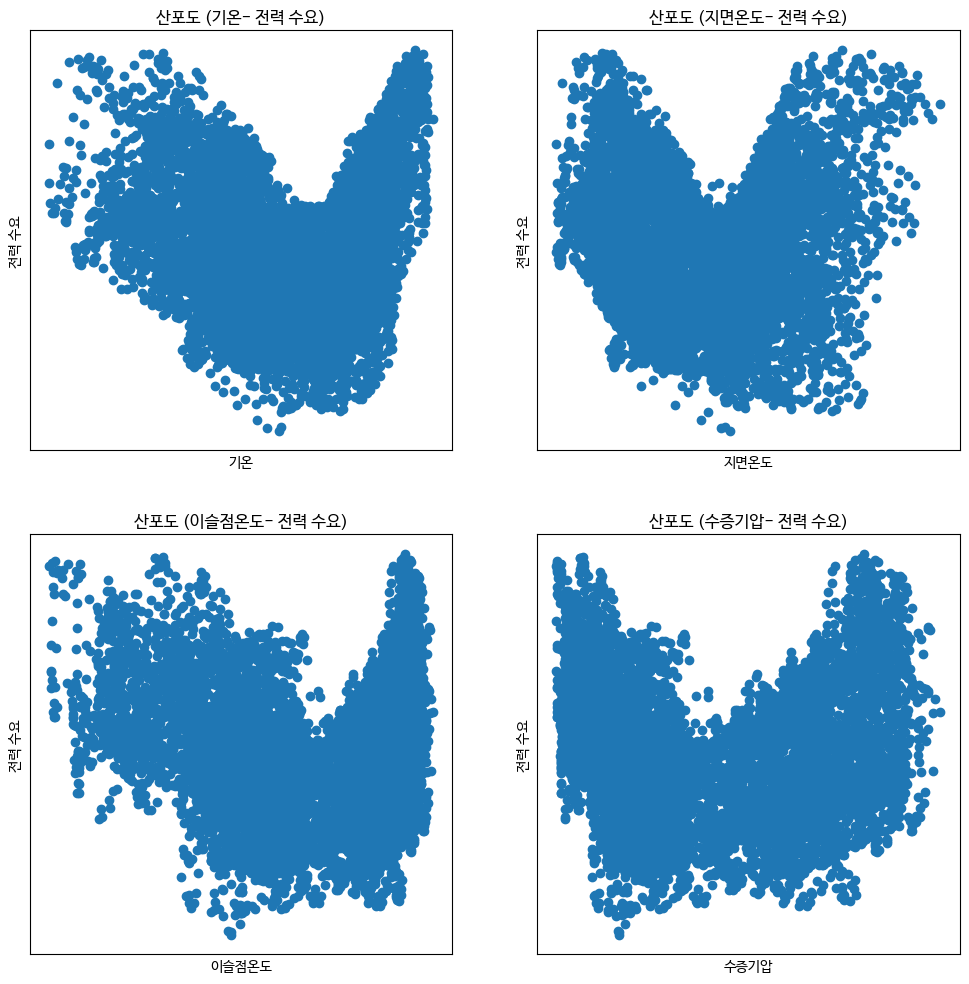

In [ ]:
# ----- 전국 평균 1시간단위 기상인자(기온, 지면온도, 이슬점온도, 수증기압)와 전력수요의 상관관계 -----

from sklearn.preprocessing import StandardScaler

# 1시간 간격의 기상인자와 전력수요 값을 연결한 데이터입니다.
df_for_EDA = pd.read_csv(PATH + 'df_for_EDA.csv', index_col = 0)

# StandarScaler로 적용
scaler = StandardScaler()
# 1년 간(24시간 * 30일 * 12개월 = 8,640개)의 기상인자와 전력수요값으로 한정
scaled_df_for_EDA = pd.DataFrame(scaler.fit_transform(df_for_EDA.iloc[:,1:]), columns = df_for_EDA.columns.values[1:]).iloc[-8640:,:]

# 산포도 그리기
weather_dict = {'TA_C' : '기온', 'TS_C' : '지면온도', 'TD_C' : '이슬점온도', 'PV_hPa' : '수증기압'}
plt.figure(figsize = (12, 12))
for idx, column in enumerate(['TA_C', 'TS_C', 'TD_C', 'PV_hPa']):
  plt.subplot(2, 2, idx+1)
  plt.title('산포도 (' + weather_dict[column] + '- 전력 수요)')
  plt.tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)
  plt.xlabel(weather_dict[column])
  plt.ylabel('전력 수요')
  plt.scatter(scaled_df_for_EDA[column], scaled_df_for_EDA['load'])

plt.show()

#### **B-4-c. 일사 및 기온 데이터와 에너지 전력 수요간의 상관성**
일사량과 에너지 전력 수요간의 상관성을 확인합니다.

Pandas computed Pearson r: 0.19590214286913626
Scipy computed Pearson r: 0.1959021428691301
Pandas computed Pearson r: -0.11979362050944004
Scipy computed Pearson r: -0.11979362050944668


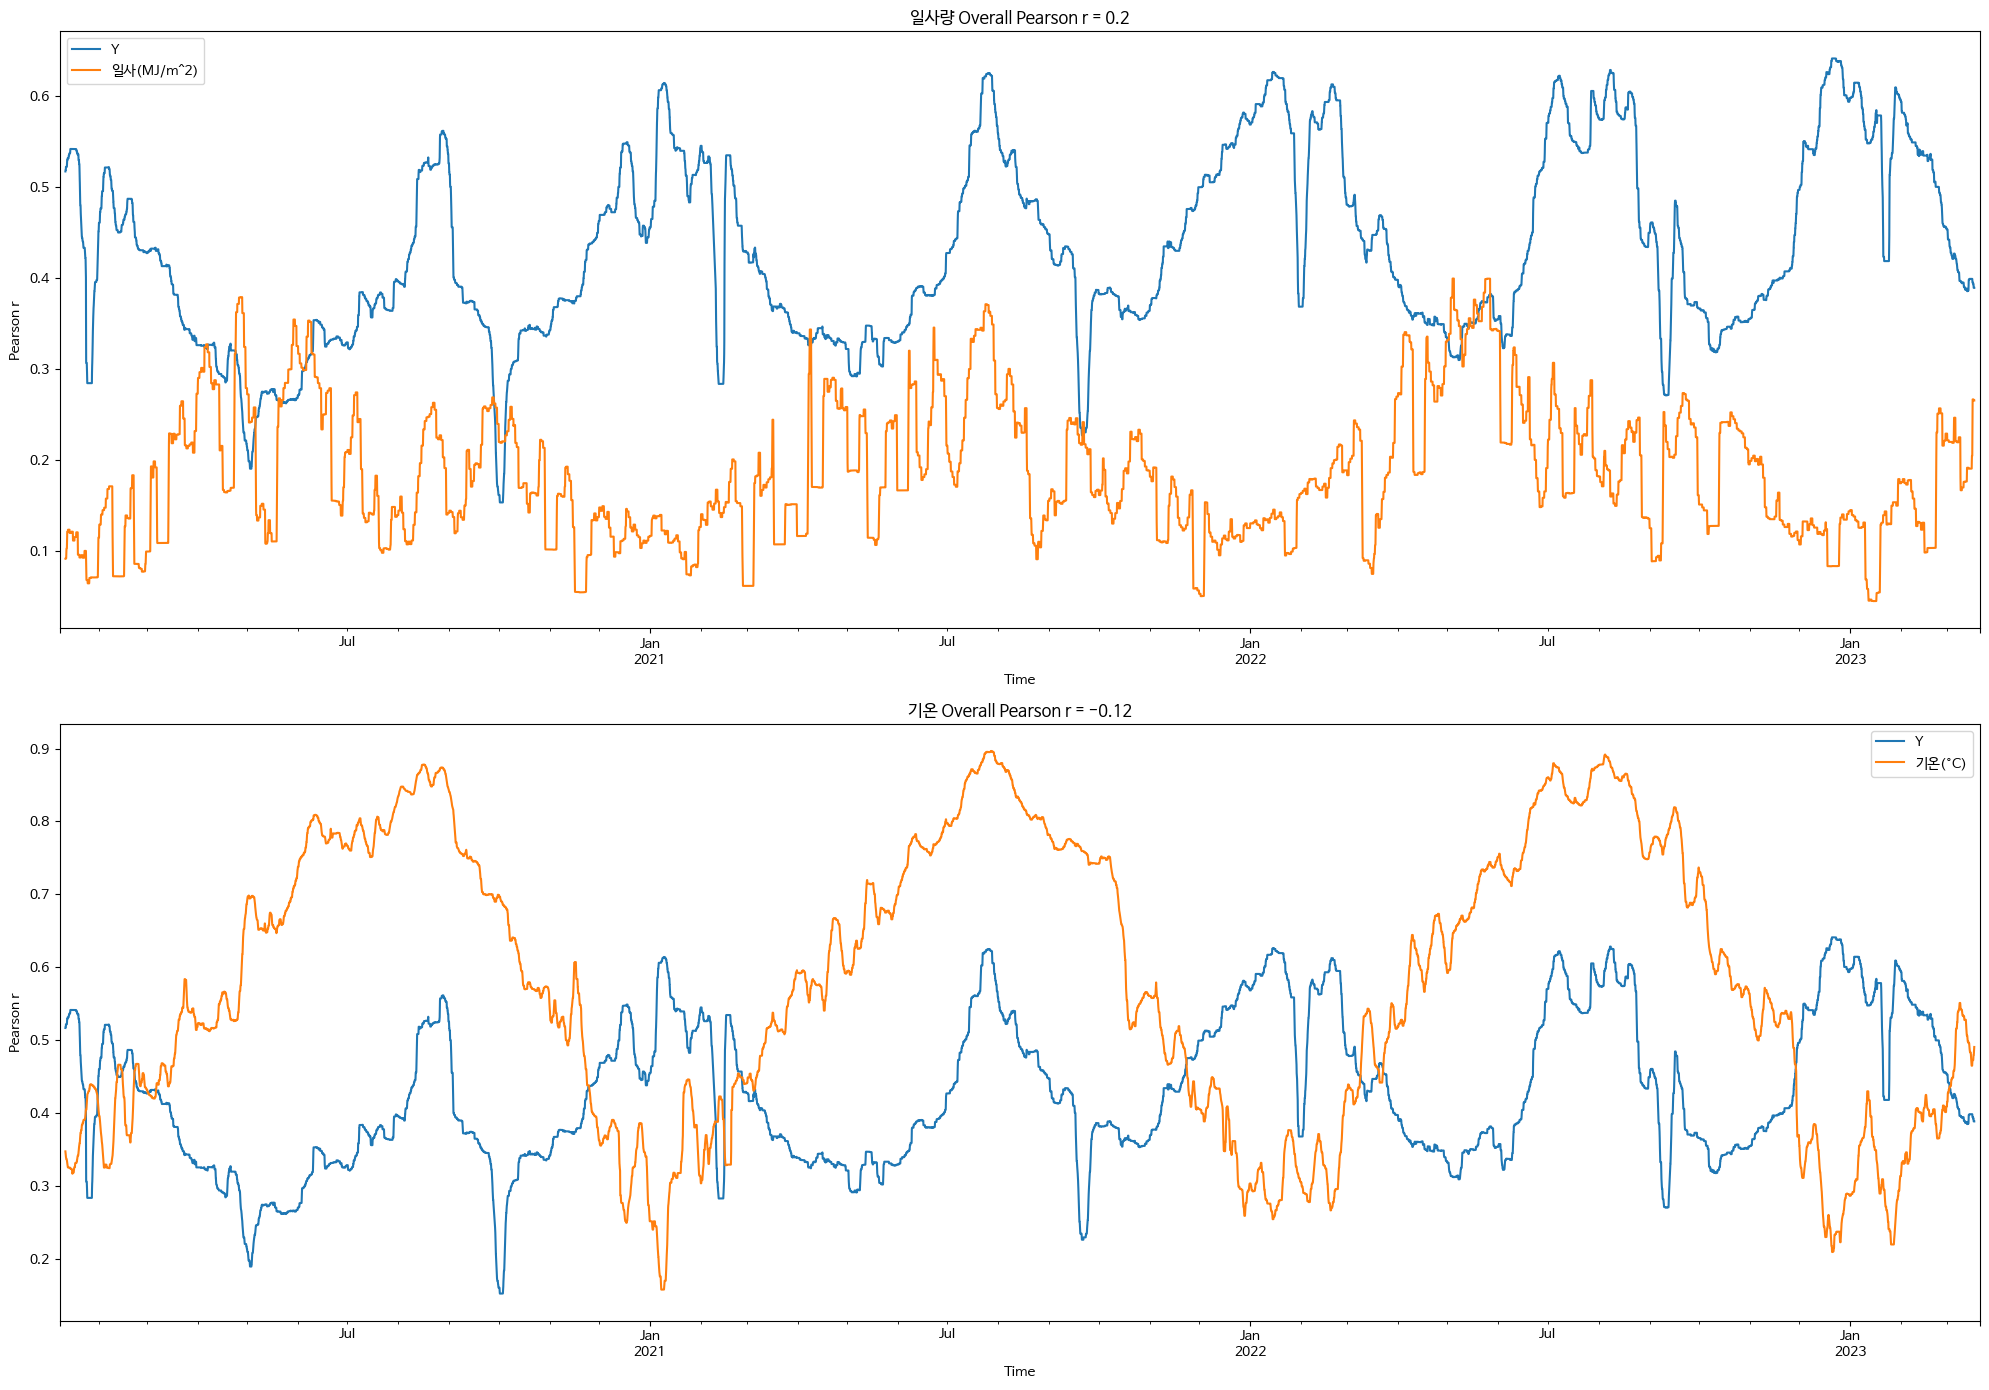

In [ ]:
## ------ 전국 전력수요 가중 평균 5분 단위 기상인자(기온, 일사량)와 전력수요의 상관관계 ------

df = pd.read_pickle(PATH + 'pre_scaled_raw_df.pkl')

import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler

tt = df.set_index('datetime')
mm = MinMaxScaler()
tt_s = mm.fit_transform(tt)
tt = pd.DataFrame(tt_s,columns=tt.columns)
tt.index = df.set_index('datetime').index


import matplotlib.pyplot as plt

a = 'Y'
b = '일사(MJ/m^2)'
tt_2 = tt[[a, b]]
tt_2.index = tt.index

overall_pearson_r = tt_2.corr().iloc[0, 1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")

r, p = stats.pearsonr(tt_2[a], tt_2[b])
print(f"Scipy computed Pearson r: {r}")

# Compute rolling window synchrony
fig, axes = plt.subplots(2, 1, figsize=(20, 14))

tt_2.rolling(window=2016, center=True).median().plot(ax=axes[0])
axes[0].set(xlabel='Time', ylabel='Pearson r')
axes[0].set(title=f"일사량 Overall Pearson r = {np.round(overall_pearson_r, 2)}")

a = 'Y'
b = '기온(°C)'
tt_2 = tt[[a, b]]
tt_2.index = tt.index

overall_pearson_r = tt_2.corr().iloc[0, 1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")

r, p = stats.pearsonr(tt_2[a], tt_2[b])
print(f"Scipy computed Pearson r: {r}")

# Compute rolling window synchrony
tt_2.rolling(window=2016, center=True).median().plot(ax=axes[1])
axes[1].set(xlabel='Time', ylabel='Pearson r')
axes[1].set(title=f"기온 Overall Pearson r = {np.round(overall_pearson_r, 2)}")

plt.tight_layout()
plt.show()


## C. **결론 및 갈무리**

- 전력 수요는 산업,일반,가정용 순으로 소요되며, 산업용 전력 수요가 과반수 이상입니다.
    - 특히 경기도, 충남, 경북이 주요 전력 수요 지역이 공업단지로, 인구대비 수요가 높습니다.
    - 연도간 일관성 있는 패턴의 요인 중 하나로 보입니다.
- 전력 수요는 폭염, 코로나 등, 계절 및 사회이슈가 선반영 되어 있음을 확인했습니다.
    - 따라서 결측이 많은 기상데이터를 활용 시, 오히려 성능이 하락할 수 있습니다.
    - 추가적으로 여름, 겨울의 경우, 봄, 가을 대비 에너지 수요량의 변동폭이 높습니다.
- 태양광 에너지는 주요 변수이나, 측정이 불가능한 한계점을 가지고 있습니다.
    - 따라서 가장 관련도가 높은 일사 데이터로 해당 영향력을 대체합니다.
- 기상 데이터 중, 기온과 일사량 데이터를 주요 변수로 활용해야 합니다.
    - 기온 데이터의 경우, 최소 최대 값이 전력 수요와 높은 상관관계를 가집니다.
    - 일사량 데이터의 경우, 기온 대비 1.7배의 전력 수요와의 상관관계를 가집니다.
    - 다만 노이즈가 많아 예측력에 지대한 영향을 끼치지는 않을것으로 판단합니다.
- 요일, 휴일, 시간은 주요 변수로 활용해야 합니다.
    - 전력수요의 경우, 요일, 휴일, 시간대에 영향을 많이 받는것으로 확인했습니다.
    - 따라서 현재 풀고자하는 단기 예측에 주요한 변수로 활용될 수 있음을 확인했습니다.


    
